In [445]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics

# Import label encoder 
from sklearn import preprocessing 

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [446]:
#Reading the dataframe
churnData = pd.read_csv("./telecom_churn_data.csv")

In [447]:
churnData.info()
#99999 rows, 226 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [448]:
churnData.filter(like='_9', axis=1).columns

#For 9th month, we need to just find out the usage details then these will be deleted

Index(['last_date_of_month_9', 'arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9', 'std_og_t2t_mou_9', 'std_og_t2m_mou_9', 'std_og_t2f_mou_9', 'std_og_t2c_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'std_ic_t2o_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'total_rech_amt_9', 'max_rech_amt_9', 'date_of_last_rech_9', 'last_day_rch_amt_9', 'date_of_last_rech_data_9', 'total_rech_data_9', 'max_rech_data_9', 'count_rech_2g_9', 'count_rech_3g_9', 'av_rech_amt_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'arpu_3g_9', 'arpu_2g_9', 'night_pck_user_9', 'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9', 'fb_user_9'], dtype='object')

2. Filter high-value customers

As mentioned above, you need to predict churn only for the high-value customers. Define high-value customers as follows: Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

In [449]:
churnData.filter(like='rech', axis=1).columns

#Multiple parameters related to recharge - new features will be derived and few will be deleted later on

Index(['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8', 'total_rech_num_9', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_amt_9', 'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'max_rech_amt_9', 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_9', 'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8', 'date_of_last_rech_data_9', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9', 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_2g_9', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'count_rech_3g_9', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9'], dtype='object')

In [450]:
churnData[['total_rech_amt_6','total_rech_amt_7']].isnull().sum()

total_rech_amt_6    0
total_rech_amt_7    0
dtype: int64

In [451]:
churnData[['total_rech_amt_6','total_rech_amt_7']].describe()

,total_rech_amt_6,total_rech_amt_7
count,99999.000000,99999.000000
mean,327.514615,322.962970
std,398.019701,408.114237
min,0.000000,0.000000
25%,109.000000,100.000000
50%,230.000000,220.000000
75%,437.500000,428.000000
max,35190.000000,40335.000000


First, calculate the total data recharge using total_rech_data * av_rech_amt_data
Then calculate the amt_rech = total_rech_amt(available in the columns) + total_data_rech(calculate before)
Use this new derived feature to filter the HVC

In [452]:
churnData.filter(like='rech').filter(like='date').columns

Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_9', 'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8', 'date_of_last_rech_data_9'], dtype='object')

In [453]:
#Adding variable LastRechDays which will return the days when customer did last recharge

churnData.date_of_last_rech_6 = pd.to_datetime(churnData.date_of_last_rech_6)
churnData.date_of_last_rech_7 = pd.to_datetime(churnData.date_of_last_rech_7)
churnData.date_of_last_rech_8 = pd.to_datetime(churnData.date_of_last_rech_8)
churnData.date_of_last_rech_data_6 = pd.to_datetime(churnData.date_of_last_rech_data_6)
churnData.date_of_last_rech_data_7 = pd.to_datetime(churnData.date_of_last_rech_data_7)
churnData.date_of_last_rech_data_8 = pd.to_datetime(churnData.date_of_last_rech_data_8)

In [454]:
#Filling Null values with default date - means no recharge is done
churnData.date_of_last_rech_6.fillna(value=pd.to_datetime('5/1/2014'), inplace=True)
churnData.date_of_last_rech_7.fillna(value=pd.to_datetime('5/1/2014'), inplace=True)
churnData.date_of_last_rech_8.fillna(value=pd.to_datetime('5/1/2014'), inplace=True)
churnData.date_of_last_rech_data_6.fillna(value=pd.to_datetime('5/1/2014'), inplace=True)
churnData.date_of_last_rech_data_7.fillna(value=pd.to_datetime('5/1/2014'), inplace=True)
churnData.date_of_last_rech_data_8.fillna(value=pd.to_datetime('5/1/2014'), inplace=True)

In [455]:
#Finding out last recharge date and filling up in new feature
#Also calculating days from last recharge - big indicator on how much long back did customer recharge

churnData['LastRechDate'] = churnData[['date_of_last_rech_6', 'date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8']].max(axis=1)

churnData['DaysFromLastRech'] = pd.to_datetime('10/1/2014') - churnData['LastRechDate']

churnData['DaysFromLastRech'] = churnData['DaysFromLastRech'].astype(dt.timedelta).map(lambda x: np.nan if pd.isnull(x) else x.days)


#Dropping all date columns

churnData.drop(['date_of_last_rech_6', 'date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8', 'LastRechDate'], axis=1, inplace=True)

In [456]:
churnData['DaysFromLastRech'].head()

0    54
1    34
2    48
3    31
4    53
Name: DaysFromLastRech, dtype: int64

In [457]:
churnData.filter(like='rech').filter(like='_6').columns

#Remaining recharge features

Index(['total_rech_num_6', 'total_rech_amt_6', 'max_rech_amt_6', 'total_rech_data_6', 'max_rech_data_6', 'count_rech_2g_6', 'count_rech_3g_6', 'av_rech_amt_data_6'], dtype='object')

In [458]:
#Filling NAN with 0 as recharge was not done for these cases

churnData['total_rech_data_6'].fillna(0,inplace=True)
churnData['total_rech_data_7'].fillna(0,inplace=True)
churnData['total_rech_data_8'].fillna(0,inplace=True)
churnData['av_rech_amt_data_6'].fillna(0,inplace=True)
churnData['av_rech_amt_data_7'].fillna(0,inplace=True)
churnData['av_rech_amt_data_8'].fillna(0,inplace=True)

In [459]:
#Calculating recharge amount for each month 6, 7, 8 - normal recharge + data recharge

churnData['rech_amt_6'] = (churnData['total_rech_data_6'] * churnData['av_rech_amt_data_6']) + churnData['total_rech_amt_6']
churnData['rech_amt_7'] = (churnData['total_rech_data_7'] * churnData['av_rech_amt_data_7']) + churnData['total_rech_amt_7']
churnData['rech_amt_8'] = (churnData['total_rech_data_8'] * churnData['av_rech_amt_data_8']) + churnData['total_rech_amt_8']

In [460]:
#Recharge columns will not be needed now - deleting leaving max columns - might be relevant for model

churnData.drop(['total_rech_amt_6', 'total_rech_data_6', 'count_rech_2g_6', 'count_rech_3g_6', 'av_rech_amt_data_6'], inplace=True, axis=1)
churnData.drop(['total_rech_amt_7', 'total_rech_data_7', 'count_rech_2g_7', 'count_rech_3g_7', 'av_rech_amt_data_7'], inplace=True, axis=1)
churnData.drop(['total_rech_amt_8', 'total_rech_data_8', 'count_rech_2g_8', 'count_rech_3g_8', 'av_rech_amt_data_8'], inplace=True, axis=1)

In [461]:
#Filtering High value customers as per the definition given in assignment

churnData['rech_avg'] = (churnData['rech_amt_6'] + churnData['rech_amt_7'] )/2

churnData['rech_avg'].describe()

churnDataHighEndCust = churnData.loc[churnData['rech_avg'] > churnData['rech_avg'].quantile(0.7) ]

#churnDataHighEndCust will be used going forward as having High Value Customer

In [462]:
churnDataHighEndCust.shape

#After filtering the high-value customers, you should get about 29.9k rows.--> Correct so far

(29953, 210)

In [463]:
churnData['rech_avg'].quantile(0.7)

478.0

In [464]:
#Customer will churn if total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9 are zero
#churnDataHighEndCust['churn'] = 0

def findChurn(cols):
    if ((cols[0] == 0) and (cols[1] == 0) and (cols[2] == 0) and (cols[3] == 0)):
        return 1
    else:
        return 0

churnDataHighEndCust['churn'] = churnDataHighEndCust[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']].apply(findChurn, axis=1)

In [465]:
churnDataHighEndCust['churn'].value_counts()
#<10% are marked as churn

0    27520
1     2433
Name: churn, dtype: int64

In [466]:
churnDataHighEndCust.filter(like='_9', axis=1).columns

Index(['last_date_of_month_9', 'arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9', 'std_og_t2t_mou_9', 'std_og_t2m_mou_9', 'std_og_t2f_mou_9', 'std_og_t2c_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'std_ic_t2o_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'total_rech_amt_9', 'max_rech_amt_9', 'date_of_last_rech_9', 'last_day_rch_amt_9', 'date_of_last_rech_data_9', 'total_rech_data_9', 'max_rech_data_9', 'count_rech_2g_9', 'count_rech_3g_9', 'av_rech_amt_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'arpu_3g_9', 'arpu_2g_9', 'night_pck_user_9', 'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9', 'fb_user_9'], dtype='object')

In [467]:
#All attributes with suffix _9 are to be deleted now

churnDataHighEndCust.drop(churnDataHighEndCust.filter(like='_9', axis=1).columns, axis=1, inplace=True)

In [468]:
churnDataHighEndCust.shape

(29953, 157)

In [469]:
#Starting with data clean-up on churnDataHighEndCust dataset

In [470]:
churnDataHighEndCust.filter(like='arpu', axis=1).head()

,arpu_6,arpu_7,arpu_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8
0,197.385,214.816,213.803,212.17,212.17,212.17,212.17,212.17,212.17
7,1069.180,1349.850,3171.480,NaN,NaN,NaN,NaN,NaN,NaN
8,378.721,492.223,137.362,NaN,0.00,19.83,NaN,0.00,0.00
21,514.453,597.753,637.760,NaN,NaN,NaN,NaN,NaN,NaN
23,74.350,193.897,366.966,NaN,306.57,197.27,NaN,301.78,150.67


In [471]:
#Arpu for 6,7,8 is not null, with suffix 2g and 3g is null mean no revenue thus filling with 0
print(churnDataHighEndCust.arpu_6.isnull().sum())
print(churnDataHighEndCust.arpu_7.isnull().sum())
print(churnDataHighEndCust.arpu_8.isnull().sum())

churnDataHighEndCust.arpu_2g_6.fillna(0, inplace=True)
churnDataHighEndCust.arpu_3g_6.fillna(0, inplace=True)

churnDataHighEndCust.arpu_2g_7.fillna(0, inplace=True)
churnDataHighEndCust.arpu_3g_7.fillna(0, inplace=True)

churnDataHighEndCust.arpu_2g_8.fillna(0, inplace=True)
churnDataHighEndCust.arpu_3g_8.fillna(0, inplace=True)

0
0
0


In [472]:
round(100*churnDataHighEndCust.isnull().sum()/len(churnDataHighEndCust.index),2).sort_values(ascending=False).head(10)

night_pck_user_8    46.80
max_rech_data_8     46.80
fb_user_8           46.80
night_pck_user_6    44.11
max_rech_data_6     44.11
fb_user_6           44.11
night_pck_user_7    43.12
max_rech_data_7     43.12
fb_user_7           43.12
loc_og_mou_8         3.91
dtype: float64

In [473]:
#Deleting max_rech_data_8, night_pck_user_8, fb_user_8 - from 8th month because of 46.8% NaN values

churnDataHighEndCust.drop(['max_rech_data_6','max_rech_data_7','max_rech_data_8'], axis=1, inplace=True)
#Filling up fb_user, night_pck_user with 0 as these are Null as service is not being used. 

churnDataHighEndCust.night_pck_user_6.fillna(0, inplace=True)
churnDataHighEndCust.night_pck_user_7.fillna(0, inplace=True)
churnDataHighEndCust.night_pck_user_8.fillna(0, inplace=True)

churnDataHighEndCust.fb_user_6.fillna(0, inplace=True)
churnDataHighEndCust.fb_user_7.fillna(0, inplace=True)
churnDataHighEndCust.fb_user_8.fillna(0, inplace=True)

In [474]:
round(100*churnDataHighEndCust.isnull().sum()/len(churnDataHighEndCust.index),2).sort_values(ascending=False).head(30)

loc_ic_mou_8        3.91
roam_ic_mou_8       3.91
std_og_t2f_mou_8    3.91
roam_og_mou_8       3.91
std_ic_t2f_mou_8    3.91
loc_og_t2t_mou_8    3.91
std_ic_t2o_mou_8    3.91
loc_og_t2m_mou_8    3.91
std_ic_mou_8        3.91
loc_og_t2f_mou_8    3.91
std_og_t2c_mou_8    3.91
loc_og_t2c_mou_8    3.91
spl_ic_mou_8        3.91
loc_og_mou_8        3.91
isd_ic_mou_8        3.91
std_og_t2t_mou_8    3.91
ic_others_8         3.91
std_ic_t2m_mou_8    3.91
std_og_t2m_mou_8    3.91
offnet_mou_8        3.91
std_og_mou_8        3.91
onnet_mou_8         3.91
spl_og_mou_8        3.91
loc_ic_t2f_mou_8    3.91
og_others_8         3.91
loc_ic_t2m_mou_8    3.91
isd_og_mou_8        3.91
std_ic_t2t_mou_8    3.91
loc_ic_t2t_mou_8    3.91
std_ic_t2m_mou_6    1.81
dtype: float64

In [475]:
churnDataHighEndCust.shape

(29953, 154)

In [476]:
churnDataHighEndCust.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,DaysFromLastRech,rech_amt_6,rech_amt_7,rech_amt_8,rech_avg,churn
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,197.385,214.816,213.803,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.0,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.0,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,4.13,NaN,NaN,1.15,NaN,NaN,5.44,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.0,NaN,NaN,0.00,0.00,0.00,5.44,NaN,NaN,0.0,NaN,NaN,0.00,NaN,NaN,0.00,4,3,2,252,252,252,252,252,252,30.13,1.32,5.75,83.57,150.76,109.61,212.17,212.17,212.17,212.17,212.17,212.17,0.0,0.0,0.0,0,0,0,0,0,0,1,1,1,0,0,0,1.0,1.0,1.0,968,30.40,0.00,101.20,3.58,54,614.0,504.0,504.0,559.0,1
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.0,0.0,0.0,60.86,75.14,77.84,0.0,0.18,10.01,4.5,0.0,6.50,0.0,0.0,0.0,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427.88,355.23,188.04,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,0.0,0.0,0.0,180.54,173.08,193.94,626.46,558.04,428.74,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,1580,0,0,779,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,802,57.74,19.38,18.74,0.00,36,1580.0,790.0,3638.0,1185.0,1
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.0,0.0,7.15,378.09,288.18,63.04,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,0.

In [477]:
print(any(churnDataHighEndCust['mobile_number'].duplicated()))

#No duplicate mobile number

False


In [478]:
churnDataHighEndCust.select_dtypes(include=['int64']).columns

Index(['mobile_number', 'circle_id', 'total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8', 'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8', 'monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'aon', 'DaysFromLastRech', 'churn'], dtype='object')

In [479]:
churnDataHighEndCust.loc[:,churnDataHighEndCust.apply(pd.Series.nunique) == 1].columns

#To be deleted

Index(['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8'], dtype='object')

In [480]:
columnsToDelete = ['rech_avg','last_date_of_month_6','last_date_of_month_7','last_date_of_month_8','mobile_number',
                  'circle_id','loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 
       'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8',
       'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8' ]

In [481]:
print(churnDataHighEndCust.shape)
churnDataHighEndCust.drop(columnsToDelete, inplace=True, axis=1)
print(churnDataHighEndCust.shape)

#139 columns now

(29953, 154)
(29953, 139)


In [482]:
churnDataHighEndCust.select_dtypes(include=['object']).head()

""
0
7
8
21
23


In [483]:
churnDataHighEndCust.select_dtypes(include=['datetime']).head()

""
0
7
8
21
23


In [484]:
churnDataHighEndCust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29953 entries, 0 to 99997
Columns: 139 entries, arpu_6 to churn
dtypes: float64(115), int64(24)
memory usage: 32.0 MB


In [485]:
print(churnDataHighEndCust.monthly_2g_8.unique())
churnDataHighEndCust.monthly_2g_8.value_counts()*100/len(churnDataHighEndCust.index)

[0 1 2 5 3 4]


0    86.188362
1    12.442827
2     1.235269
3     0.100157
4     0.026709
5     0.006677
Name: monthly_2g_8, dtype: float64

In [486]:
#Find now if there are features where there is not much variation like >90% is being captured by a single variable

for feature in churnDataHighEndCust.columns:
    if (len(churnDataHighEndCust[feature].unique()) <10):
        print(churnDataHighEndCust[feature].value_counts()*100/len(churnDataHighEndCust.index))
        print("x-x-x-x-x-x-x-x-x")
    #print(features)

0.0    98.641205
1.0     1.358795
Name: night_pck_user_6, dtype: float64
x-x-x-x-x-x-x-x-x
0.0    98.748039
1.0     1.251961
Name: night_pck_user_7, dtype: float64
x-x-x-x-x-x-x-x-x
0.0    98.86155
1.0     1.13845
Name: night_pck_user_8, dtype: float64
x-x-x-x-x-x-x-x-x
0    84.649284
1    13.394318
2     1.839549
3     0.093480
4     0.023370
Name: monthly_2g_6, dtype: float64
x-x-x-x-x-x-x-x-x
0    84.145161
1    13.554569
2     2.166728
3     0.110173
4     0.016693
5     0.006677
Name: monthly_2g_7, dtype: float64
x-x-x-x-x-x-x-x-x
0    86.188362
1    12.442827
2     1.235269
3     0.100157
4     0.026709
5     0.006677
Name: monthly_2g_8, dtype: float64
x-x-x-x-x-x-x-x-x
1.0    51.784462
0.0    48.215538
Name: fb_user_6, dtype: float64
x-x-x-x-x-x-x-x-x
1.0    52.432144
0.0    47.567856
Name: fb_user_7, dtype: float64
x-x-x-x-x-x-x-x-x
0.0    52.268554
1.0    47.731446
Name: fb_user_8, dtype: float64
x-x-x-x-x-x-x-x-x
0    91.877274
1     8.122726
Name: churn, dtype: float64
x-x-x

In [487]:
#Not much variance is covered by night_pck_user_6/7/8 - deleting these

churnDataHighEndCust.drop(['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8'], axis=1, inplace=True)

In [488]:
churnDataHighEndCust.shape

(29953, 136)

In [489]:
churnDataHighEndCust.loc[:,churnDataHighEndCust.columns.str.contains("_8")].columns.value_counts().sum()

43

In [490]:
#Rows having all NUll values - No rows having all Null

churnDataHighEndCust.isnull().sum(axis=1).sort_values(ascending=False)
churnDataHighEndCust.isnull().all(axis=1).value_counts()

False    29953
dtype: int64

In [491]:
#Filling All other Null values as zero

churnDataHighEndCust.fillna(0, inplace=True)

In [492]:
#Create Columns having average values of 6 & 7 month

for col in churnDataHighEndCust:
    if( ("_6" in col) and (churnDataHighEndCust[col].dtype != "datetime64[ns]") ):
        #print(col)
        newColName = "Avg67_" + col[:-2]
        colName7 = col[:-2]+"_7"
                  
        #print(colName7)
        #print(churnDataHighEndCust[colName7])
        
        #print(newColName)
        
        churnDataHighEndCust[newColName] = (churnDataHighEndCust[col] + churnDataHighEndCust[colName7])/2
        churnDataHighEndCust.drop([col,colName7],axis=1, inplace=True)
        

In [493]:
for col in churnDataHighEndCust:
    if( (churnDataHighEndCust[col].dtype == "datetime64[ns]") ):
        print(col)

In [494]:
churnDataHighEndCust.filter(like = "mou").filter(like = "std").head()

,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,std_og_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,Avg67_std_og_t2t_mou,Avg67_std_og_t2m_mou,Avg67_std_og_t2f_mou,Avg67_std_og_mou,Avg67_std_ic_t2t_mou,Avg67_std_ic_t2m_mou,Avg67_std_ic_t2f_mou,Avg67_std_ic_mou
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000
7,12.01,49.14,16.68,77.84,30.39,141.33,22.21,193.94,13.795,40.825,13.37,68.000,24.360,109.215,43.215,176.810
8,22.58,75.69,0.00,98.28,0.10,0.65,0.00,0.75,124.995,11.865,0.00,136.870,0.290,13.255,0.000,13.545
21,61.79,876.99,0.00,938.79,0.18,101.74,0.00,101.93,111.935,737.050,0.00,848.990,10.020,52.960,0.000,62.985
23,0.00,39.61,0.00,39.61,13.38,43.91,0.00,57.29,0.000,4.355,0.00,4.355,0.255,8.660,0.000,8.915


In [495]:
#we dont need deep details like T2T, T2M, T2o, t2f, t2c - top level parameters are taking care of these

churnDataHighEndCust.drop(churnDataHighEndCust.filter(like='t2t').columns, axis=1, inplace=True)
churnDataHighEndCust.drop(churnDataHighEndCust.filter(like='t2m').columns, axis=1, inplace=True)
churnDataHighEndCust.drop(churnDataHighEndCust.filter(like='t2o').columns, axis=1, inplace=True)
churnDataHighEndCust.drop(churnDataHighEndCust.filter(like='t2f').columns, axis=1, inplace=True)
churnDataHighEndCust.drop(churnDataHighEndCust.filter(like='t2c').columns, axis=1, inplace=True)

In [496]:
churnDataHighEndCust.filter(like='t2f').columns

Index([], dtype='object')

In [497]:
churnDataHighEndCust.isnull().sum()

arpu_8                    0
onnet_mou_8               0
offnet_mou_8              0
roam_ic_mou_8             0
roam_og_mou_8             0
loc_og_mou_8              0
std_og_mou_8              0
isd_og_mou_8              0
spl_og_mou_8              0
og_others_8               0
total_og_mou_8            0
loc_ic_mou_8              0
std_ic_mou_8              0
total_ic_mou_8            0
spl_ic_mou_8              0
isd_ic_mou_8              0
ic_others_8               0
total_rech_num_8          0
max_rech_amt_8            0
last_day_rch_amt_8        0
vol_2g_mb_8               0
vol_3g_mb_8               0
arpu_3g_8                 0
arpu_2g_8                 0
monthly_2g_8              0
sachet_2g_8               0
monthly_3g_8              0
sachet_3g_8               0
fb_user_8                 0
aon                       0
aug_vbc_3g                0
jul_vbc_3g                0
jun_vbc_3g                0
sep_vbc_3g                0
DaysFromLastRech          0
rech_amt_8          

In [498]:
churnDataHighEndCust.head()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,total_og_mou_8,loc_ic_mou_8,std_ic_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,max_rech_amt_8,last_day_rch_amt_8,vol_2g_mb_8,vol_3g_mb_8,arpu_3g_8,arpu_2g_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,DaysFromLastRech,rech_amt_8,churn,Avg67_arpu,Avg67_onnet_mou,Avg67_offnet_mou,Avg67_roam_ic_mou,Avg67_roam_og_mou,Avg67_loc_og_mou,Avg67_std_og_mou,Avg67_isd_og_mou,Avg67_spl_og_mou,Avg67_og_others,Avg67_total_og_mou,Avg67_loc_ic_mou,Avg67_std_ic_mou,Avg67_total_ic_mou,Avg67_spl_ic_mou,Avg67_isd_ic_mou,Avg67_ic_others,Avg67_total_rech_num,Avg67_max_rech_amt,Avg67_last_day_rch_amt,Avg67_vol_2g_mb,Avg67_vol_3g_mb,Avg67_arpu_3g,Avg67_arpu_2g,Avg67_monthly_2g,Avg67_sachet_2g,Avg67_monthly_3g,Avg67_sachet_3g,Avg67_fb_user,Avg67_rech_amt
0,213.803,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,5.44,0.00,5.44,0.0,0.00,0.00,2,252,252,5.75,109.61,212.17,212.17,0,0,1,0,1.0,968,30.40,0.00,101.20,3.58,54,504.0,1,206.1005,0.00,0.000,0.00,0.000,0.000,0.000,0.000,0.00,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.5,252.0,252.0,15.725,117.165,212.170,212.17,0.0,0.0,1.0,0.0,1.0,559.0
7,3171.480,52.29,325.91,31.64,38.06,255.79,77.84,10.01,6.50,0.0,350.16,188.04,193.94,428.74,0.0,31.59,15.14,7,1580,779,0.00,0.00,0.00,0.00,0,0,0,0,0.0,802,57.74,19.38,18.74,0.00,36,3638.0,1,1209.5150,56.26,510.295,24.86,18.165,478.035,68.000,0.090,2.25,0.0,548.385,391.555,176.810,592.250,0.105,8.295,15.465,5.0,1185.0,0.0,0.000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,1185.0
8,137.362,35.08,136.48,0.00,0.00,63.04,98.28,0.00,10.23,0.0,171.56,15.79,0.75,16.54,0.0,0.00,0.00,14,30,10,0.03,11.94,19.83,0.00,0,3,0,0,1.0,315,21.03,910.65,122.16,0.00,32,327.0,0,435.4720,382.36,87.645,0.00,0.000,333.135,136.870,0.000,0.00,0.0,470.010,52.630,13.545,66.175,0.000,0.000,0.000,20.0,122.0,25.0,178.000,375.475,0.000,0.00,0.5,0.5,0.0,0.0,0.5,696.0
21,637.760,85.14,983.39,0.00,0.00,129.74,938.79,0.00,0.00,0.0,1068.54,159.11,101.93,261.04,0.0,0.00,0.00,27,50,50,0.00,0.00,0.00,0.00,0,0,0,0,0.0,720,0.00,0.00,0.00,0.00,31,718.0,0,556.1030,117.26,827.305,0.00,0.000,95.565,848.990,0.000,0.00,0.0,944.565,106.505,62.985,169.490,0.000,0.000,0.000,24.0,50.0,25.0,0.000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,640.0
23,366.966,33.58,205.89,0.00,0.00,182.14,39.61,0.00,17.71,0.0,239.48,224.21,57.29,298.33,0.0,3.74,13.06,4,179,0,0.01,1009.92,197.27,150.67,0,0,1,1,1.0,604,40.45,51.86,0.00,0.00,38,979.0,0,134.1235,49.81,87.385,0.00,0.000,132.795,4.355,0.005,0.05,0.0,137.210,145.520,8.915,171.235,0.000,14.115,2.675,4.0,89.5,89.5,0.240,299.545,153.285,150.89,0.0,0.0,1.0,0.0,0.5,583.0


In [499]:
churnDataHighEndCust.filter(like = "Avg67").head()

,Avg67_arpu,Avg67_onnet_mou,Avg67_offnet_mou,Avg67_roam_ic_mou,Avg67_roam_og_mou,Avg67_loc_og_mou,Avg67_std_og_mou,Avg67_isd_og_mou,Avg67_spl_og_mou,Avg67_og_others,Avg67_total_og_mou,Avg67_loc_ic_mou,Avg67_std_ic_mou,Avg67_total_ic_mou,Avg67_spl_ic_mou,Avg67_isd_ic_mou,Avg67_ic_others,Avg67_total_rech_num,Avg67_max_rech_amt,Avg67_last_day_rch_amt,Avg67_vol_2g_mb,Avg67_vol_3g_mb,Avg67_arpu_3g,Avg67_arpu_2g,Avg67_monthly_2g,Avg67_sachet_2g,Avg67_monthly_3g,Avg67_sachet_3g,Avg67_fb_user,Avg67_rech_amt
0,206.1005,0.00,0.000,0.00,0.000,0.000,0.000,0.000,0.00,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.5,252.0,252.0,15.725,117.165,212.170,212.17,0.0,0.0,1.0,0.0,1.0,559.0
7,1209.5150,56.26,510.295,24.86,18.165,478.035,68.000,0.090,2.25,0.0,548.385,391.555,176.810,592.250,0.105,8.295,15.465,5.0,1185.0,0.0,0.000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,1185.0
8,435.4720,382.36,87.645,0.00,0.000,333.135,136.870,0.000,0.00,0.0,470.010,52.630,13.545,66.175,0.000,0.000,0.000,20.0,122.0,25.0,178.000,375.475,0.000,0.00,0.5,0.5,0.0,0.0,0.5,696.0
21,556.1030,117.26,827.305,0.00,0.000,95.565,848.990,0.000,0.00,0.0,944.565,106.505,62.985,169.490,0.000,0.000,0.000,24.0,50.0,25.0,0.000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,640.0
23,134.1235,49.81,87.385,0.00,0.000,132.795,4.355,0.005,0.05,0.0,137.210,145.520,8.915,171.235,0.000,14.115,2.675,4.0,89.5,89.5,0.240,299.545,153.285,150.89,0.0,0.0,1.0,0.0,0.5,583.0


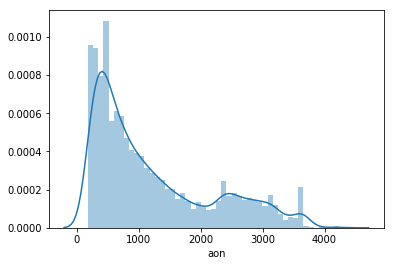

In [500]:
#aon', 'aug_vbc_3g',     'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g', 'churn'

#churnDataHighEndCust

sns.distplot(churnDataHighEndCust['aon'])
plt.show()

#more customers which are less than 500 days

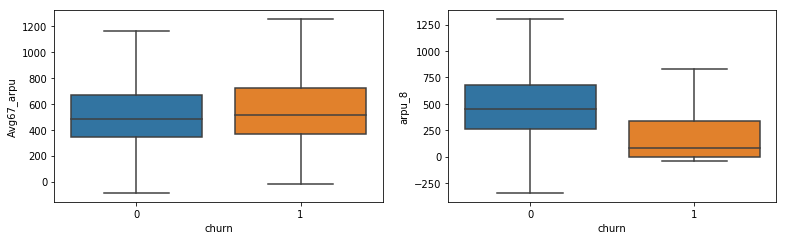

In [501]:
#Compare ARPU for Avg67 and 8 month for 1 and 0 churn

plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(x = 'churn', y = 'Avg67_arpu', data = churnDataHighEndCust, showfliers=False)
plt.subplot(3,3,2)
sns.boxplot(x = 'churn', y = 'arpu_8', data = churnDataHighEndCust, showfliers=False)

#Very less revenue from Churn customers in 8th month

In [502]:
churnDataHighEndCust.filter(like = "mou").filter(like = "_8").head()

,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,total_og_mou_8,loc_ic_mou_8,std_ic_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.44,0.00,5.44,0.0,0.00
7,52.29,325.91,31.64,38.06,255.79,77.84,10.01,6.50,350.16,188.04,193.94,428.74,0.0,31.59
8,35.08,136.48,0.00,0.00,63.04,98.28,0.00,10.23,171.56,15.79,0.75,16.54,0.0,0.00
21,85.14,983.39,0.00,0.00,129.74,938.79,0.00,0.00,1068.54,159.11,101.93,261.04,0.0,0.00
23,33.58,205.89,0.00,0.00,182.14,39.61,0.00,17.71,239.48,224.21,57.29,298.33,0.0,3.74


In [503]:
#Avg67_loc_og_t2t_mou+Avg67_loc_og_t2m_mou+Avg67_loc_og_t2f_mou+Avg67_loc_og_t2c_mou = Avg67_loc_og_mou
#Thus deleting these 4 varaibles - not needed
#Avg67_loc_ic_t2t_mou + Avg67_loc_ic_t2m_mou + Avg67_loc_ic_t2f_mou = Avg67_loc_ic_mou
#churnDataHighEndCust.drop( ['Avg67_loc_og_t2t_mou','Avg67_loc_og_t2m_mou','Avg67_loc_og_t2f_mou','Avg67_loc_og_t2c_mou', 'Avg67_loc_ic_t2t_mou','Avg67_loc_ic_t2m_mou','Avg67_loc_ic_t2f_mou'],axis=1, inplace=True)

In [504]:
churnDataHighEndCust.filter(like = "mou").filter(like = "Avg").head()

,Avg67_onnet_mou,Avg67_offnet_mou,Avg67_roam_ic_mou,Avg67_roam_og_mou,Avg67_loc_og_mou,Avg67_std_og_mou,Avg67_isd_og_mou,Avg67_spl_og_mou,Avg67_total_og_mou,Avg67_loc_ic_mou,Avg67_std_ic_mou,Avg67_total_ic_mou,Avg67_spl_ic_mou,Avg67_isd_ic_mou
0,0.00,0.000,0.00,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000
7,56.26,510.295,24.86,18.165,478.035,68.000,0.090,2.25,548.385,391.555,176.810,592.250,0.105,8.295
8,382.36,87.645,0.00,0.000,333.135,136.870,0.000,0.00,470.010,52.630,13.545,66.175,0.000,0.000
21,117.26,827.305,0.00,0.000,95.565,848.990,0.000,0.00,944.565,106.505,62.985,169.490,0.000,0.000
23,49.81,87.385,0.00,0.000,132.795,4.355,0.005,0.05,137.210,145.520,8.915,171.235,0.000,14.115


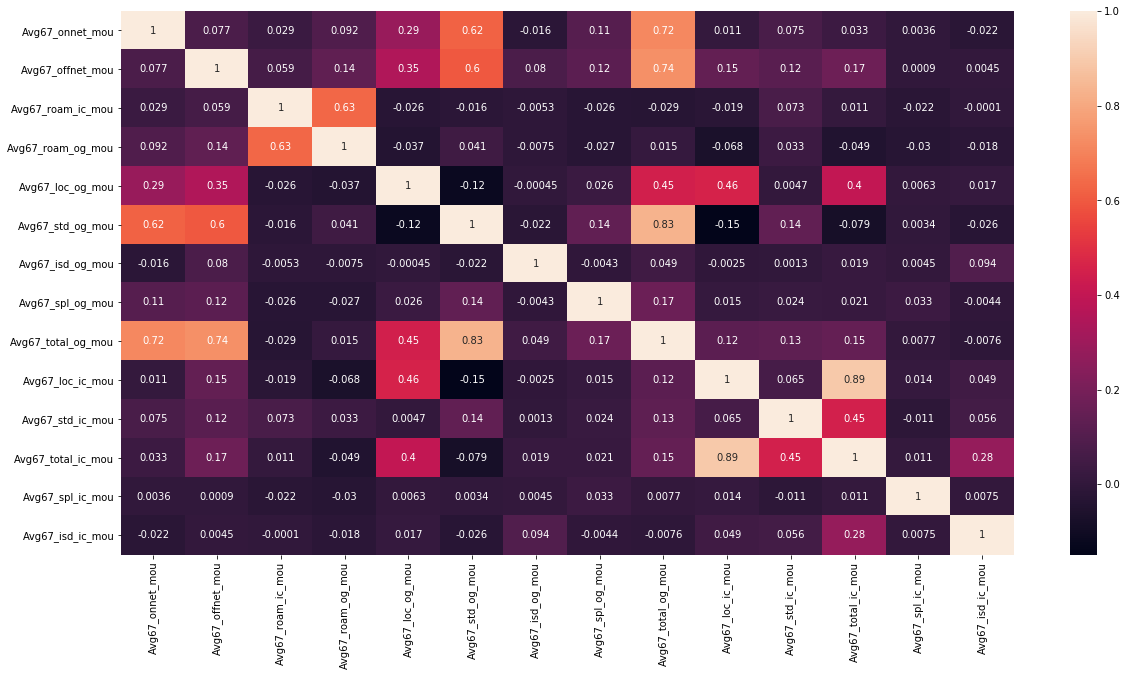

In [505]:
plt.figure(figsize = (20,10))
sns.heatmap(churnDataHighEndCust.filter(like = "mou").filter(like = "Avg").corr(),annot = True)
plt.show()

In [506]:
#Deleting highly correlated columns - 
#Avg67_loc_ic_mou, Avg67_std_ic_t2t_mou, Avg67_std_ic_t2t_mou, Avg67_std_ic_t2f_mou, Avg67_std_ic_t2m_mou,Avg67_std_og_t2t_mou, Avg67_std_og_t2m_mou,Avg67_std_og_t2f_mou  

#churnDataHighEndCust.drop(['Avg67_std_ic_t2t_mou', 'Avg67_std_ic_t2t_mou', 'Avg67_std_ic_t2f_mou','Avg67_std_ic_t2m_mou','Avg67_std_og_t2t_mou', 'Avg67_std_og_t2m_mou','Avg67_std_og_t2f_mou'  ], axis=1, inplace=True)

In [507]:
churnDataHighEndCust['Avg67_mou'] = churnDataHighEndCust['Avg67_onnet_mou'] + churnDataHighEndCust['Avg67_offnet_mou']
churnDataHighEndCust['mou_8'] = churnDataHighEndCust['onnet_mou_8'] + churnDataHighEndCust['offnet_mou_8']

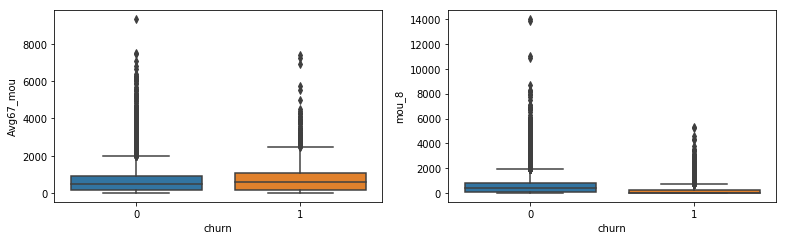

In [508]:
plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(x = 'churn', y = 'Avg67_mou', data = churnDataHighEndCust)
plt.subplot(3,3,2)
sns.boxplot(x = 'churn', y = 'mou_8', data = churnDataHighEndCust)

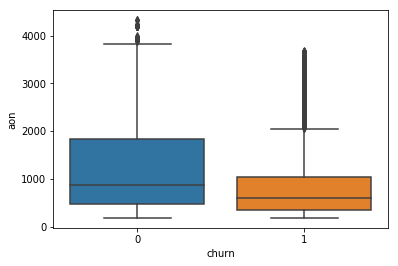

In [509]:
churnDataHighEndCust.filter(like = "aon").head()

sns.boxplot(x = 'churn', y = 'aon', data = churnDataHighEndCust)
#People using the network for more time does not churn so much as compared to new comers

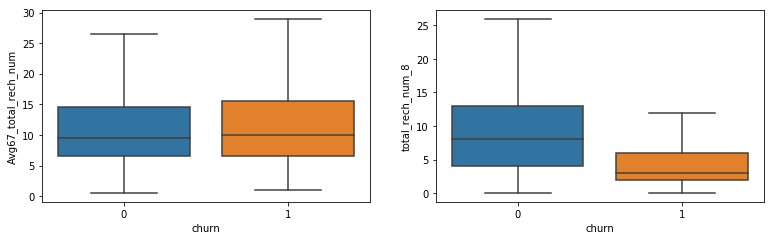

In [510]:
plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(x = 'churn', y = 'Avg67_total_rech_num', data = churnDataHighEndCust, showfliers=False)
plt.subplot(3,3,2)
sns.boxplot(x = 'churn', y = 'total_rech_num_8', data = churnDataHighEndCust, showfliers=False)

#Recharge number looks to be going down drastically for churn customers

In [511]:
churnDataHighEndCust['Avg67_vbc_3g'] = (churnDataHighEndCust['jun_vbc_3g'] + churnDataHighEndCust['jul_vbc_3g']) /2

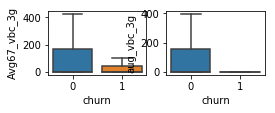

In [512]:
plt.subplot(3,3,1)
sns.boxplot(x = 'churn', y = 'Avg67_vbc_3g', data = churnDataHighEndCust, showfliers=False)
plt.subplot(3,3,2)
sns.boxplot(x = 'churn', y = 'aug_vbc_3g', data = churnDataHighEndCust, showfliers=False)

In [513]:
#Deleting more columns which does not look relevant
churnDataHighEndCust.drop(['jun_vbc_3g','jul_vbc_3g','Avg67_onnet_mou','Avg67_offnet_mou'], axis=1, inplace=True)

In [514]:
churnDataHighEndCust.columns

Index(['arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8', 'roam_og_mou_8', 'loc_og_mou_8', 'std_og_mou_8', 'isd_og_mou_8', 'spl_og_mou_8', 'og_others_8', 'total_og_mou_8', 'loc_ic_mou_8', 'std_ic_mou_8', 'total_ic_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8', 'total_rech_num_8', 'max_rech_amt_8', 'last_day_rch_amt_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'arpu_3g_8', 'arpu_2g_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'fb_user_8', 'aon', 'aug_vbc_3g', 'sep_vbc_3g', 'DaysFromLastRech', 'rech_amt_8', 'churn', 'Avg67_arpu', 'Avg67_roam_ic_mou', 'Avg67_roam_og_mou', 'Avg67_loc_og_mou', 'Avg67_std_og_mou', 'Avg67_isd_og_mou', 'Avg67_spl_og_mou', 'Avg67_og_others', 'Avg67_total_og_mou', 'Avg67_loc_ic_mou', 'Avg67_std_ic_mou', 'Avg67_total_ic_mou', 'Avg67_spl_ic_mou', 'Avg67_isd_ic_mou', 'Avg67_ic_others', 'Avg67_total_rech_num', 'Avg67_max_rech_amt', 'Avg67_last_day_rch_amt', 'Avg67_vol_2g_mb', 'Avg67_vol_3g_mb', 'Avg67_arpu_3g', 'Avg67_arpu_2g',
       'Avg67

In [515]:
churnDataHighEndCust.loc_og_mou_8.sum()

7064808.0200000005

In [516]:
churnDataHighEndCust.filter(like='aon', axis=1).columns

Index(['aon'], dtype='object')

In [517]:
churnDataHighEndCust.head()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,total_og_mou_8,loc_ic_mou_8,std_ic_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,max_rech_amt_8,last_day_rch_amt_8,vol_2g_mb_8,vol_3g_mb_8,arpu_3g_8,arpu_2g_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,fb_user_8,aon,aug_vbc_3g,sep_vbc_3g,DaysFromLastRech,rech_amt_8,churn,Avg67_arpu,Avg67_roam_ic_mou,Avg67_roam_og_mou,Avg67_loc_og_mou,Avg67_std_og_mou,Avg67_isd_og_mou,Avg67_spl_og_mou,Avg67_og_others,Avg67_total_og_mou,Avg67_loc_ic_mou,Avg67_std_ic_mou,Avg67_total_ic_mou,Avg67_spl_ic_mou,Avg67_isd_ic_mou,Avg67_ic_others,Avg67_total_rech_num,Avg67_max_rech_amt,Avg67_last_day_rch_amt,Avg67_vol_2g_mb,Avg67_vol_3g_mb,Avg67_arpu_3g,Avg67_arpu_2g,Avg67_monthly_2g,Avg67_sachet_2g,Avg67_monthly_3g,Avg67_sachet_3g,Avg67_fb_user,Avg67_rech_amt,Avg67_mou,mou_8,Avg67_vbc_3g
0,213.803,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,5.44,0.00,5.44,0.0,0.00,0.00,2,252,252,5.75,109.61,212.17,212.17,0,0,1,0,1.0,968,30.40,3.58,54,504.0,1,206.1005,0.00,0.000,0.000,0.000,0.000,0.00,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.5,252.0,252.0,15.725,117.165,212.170,212.17,0.0,0.0,1.0,0.0,1.0,559.0,0.000,0.00,50.600
7,3171.480,52.29,325.91,31.64,38.06,255.79,77.84,10.01,6.50,0.0,350.16,188.04,193.94,428.74,0.0,31.59,15.14,7,1580,779,0.00,0.00,0.00,0.00,0,0,0,0,0.0,802,57.74,0.00,36,3638.0,1,1209.5150,24.86,18.165,478.035,68.000,0.090,2.25,0.0,548.385,391.555,176.810,592.250,0.105,8.295,15.465,5.0,1185.0,0.0,0.000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,1185.0,566.555,378.20,19.060
8,137.362,35.08,136.48,0.00,0.00,63.04,98.28,0.00,10.23,0.0,171.56,15.79,0.75,16.54,0.0,0.00,0.00,14,30,10,0.03,11.94,19.83,0.00,0,3,0,0,1.0,315,21.03,0.00,32,327.0,0,435.4720,0.00,0.000,333.135,136.870,0.000,0.00,0.0,470.010,52.630,13.545,66.175,0.000,0.000,0.000,20.0,122.0,25.0,178.000,375.475,0.000,0.00,0.5,0.5,0.0,0.0,0.5,696.0,470.005,171.56,516.405
21,637.760,85.14,983.39,0.00,0.00,129.74,938.79,0.00,0.00,0.0,1068.54,159.11,101.93,261.04,0.0,0.00,0.00,27,50,50,0.00,0.00,0.00,0.00,0,0,0,0,0.0,720,0.00,0.00,31,718.0,0,556.1030,0.00,0.000,95.565,848.990,0.000,0.00,0.0,944.565,106.505,62.985,169.490,0.000,0.000,0.000,24.0,50.0,25.0,0.000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,640.0,944.565,1068.53,0.000
23,366.966,33.58,205.89,0.00,0.00,182.14,39.61,0.00,17.71,0.0,239.48,224.21,57.29,298.33,0.0,3.74,13.06,4,179,0,0.01,1009.92,197.27,150.67,0,0,1,1,1.0,604,40.45,0.00,38,979.0,0,134.1235,0.00,0.000,132.795,4.355,0.005,0.05,0.0,137.210,145.520,8.915,171.235,0.000,14.115,2.675,4.0,89.5,89.5,0.240,299.545,153.285,150.89,0.0,0.0,1.0,0.0,0.5,583.0,137.195,239.47,25.930


In [518]:
churnDataHighEndCust.fillna(0,inplace=True)

In [519]:
churnDataHighEndCust.isnull().sum()


arpu_8                    0
onnet_mou_8               0
offnet_mou_8              0
roam_ic_mou_8             0
roam_og_mou_8             0
loc_og_mou_8              0
std_og_mou_8              0
isd_og_mou_8              0
spl_og_mou_8              0
og_others_8               0
total_og_mou_8            0
loc_ic_mou_8              0
std_ic_mou_8              0
total_ic_mou_8            0
spl_ic_mou_8              0
isd_ic_mou_8              0
ic_others_8               0
total_rech_num_8          0
max_rech_amt_8            0
last_day_rch_amt_8        0
vol_2g_mb_8               0
vol_3g_mb_8               0
arpu_3g_8                 0
arpu_2g_8                 0
monthly_2g_8              0
sachet_2g_8               0
monthly_3g_8              0
sachet_3g_8               0
fb_user_8                 0
aon                       0
aug_vbc_3g                0
sep_vbc_3g                0
DaysFromLastRech          0
rech_amt_8                0
churn                     0
Avg67_arpu          

### PCA

In [520]:
dat_churn=churnDataHighEndCust

In [521]:
dat=dat_churn.drop(['churn'],axis=1)

In [522]:
dat.head()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,total_og_mou_8,loc_ic_mou_8,std_ic_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,max_rech_amt_8,last_day_rch_amt_8,vol_2g_mb_8,vol_3g_mb_8,arpu_3g_8,arpu_2g_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,fb_user_8,aon,aug_vbc_3g,sep_vbc_3g,DaysFromLastRech,rech_amt_8,Avg67_arpu,Avg67_roam_ic_mou,Avg67_roam_og_mou,Avg67_loc_og_mou,Avg67_std_og_mou,Avg67_isd_og_mou,Avg67_spl_og_mou,Avg67_og_others,Avg67_total_og_mou,Avg67_loc_ic_mou,Avg67_std_ic_mou,Avg67_total_ic_mou,Avg67_spl_ic_mou,Avg67_isd_ic_mou,Avg67_ic_others,Avg67_total_rech_num,Avg67_max_rech_amt,Avg67_last_day_rch_amt,Avg67_vol_2g_mb,Avg67_vol_3g_mb,Avg67_arpu_3g,Avg67_arpu_2g,Avg67_monthly_2g,Avg67_sachet_2g,Avg67_monthly_3g,Avg67_sachet_3g,Avg67_fb_user,Avg67_rech_amt,Avg67_mou,mou_8,Avg67_vbc_3g
0,213.803,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,5.44,0.00,5.44,0.0,0.00,0.00,2,252,252,5.75,109.61,212.17,212.17,0,0,1,0,1.0,968,30.40,3.58,54,504.0,206.1005,0.00,0.000,0.000,0.000,0.000,0.00,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.5,252.0,252.0,15.725,117.165,212.170,212.17,0.0,0.0,1.0,0.0,1.0,559.0,0.000,0.00,50.600
7,3171.480,52.29,325.91,31.64,38.06,255.79,77.84,10.01,6.50,0.0,350.16,188.04,193.94,428.74,0.0,31.59,15.14,7,1580,779,0.00,0.00,0.00,0.00,0,0,0,0,0.0,802,57.74,0.00,36,3638.0,1209.5150,24.86,18.165,478.035,68.000,0.090,2.25,0.0,548.385,391.555,176.810,592.250,0.105,8.295,15.465,5.0,1185.0,0.0,0.000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,1185.0,566.555,378.20,19.060
8,137.362,35.08,136.48,0.00,0.00,63.04,98.28,0.00,10.23,0.0,171.56,15.79,0.75,16.54,0.0,0.00,0.00,14,30,10,0.03,11.94,19.83,0.00,0,3,0,0,1.0,315,21.03,0.00,32,327.0,435.4720,0.00,0.000,333.135,136.870,0.000,0.00,0.0,470.010,52.630,13.545,66.175,0.000,0.000,0.000,20.0,122.0,25.0,178.000,375.475,0.000,0.00,0.5,0.5,0.0,0.0,0.5,696.0,470.005,171.56,516.405
21,637.760,85.14,983.39,0.00,0.00,129.74,938.79,0.00,0.00,0.0,1068.54,159.11,101.93,261.04,0.0,0.00,0.00,27,50,50,0.00,0.00,0.00,0.00,0,0,0,0,0.0,720,0.00,0.00,31,718.0,556.1030,0.00,0.000,95.565,848.990,0.000,0.00,0.0,944.565,106.505,62.985,169.490,0.000,0.000,0.000,24.0,50.0,25.0,0.000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,640.0,944.565,1068.53,0.000
23,366.966,33.58,205.89,0.00,0.00,182.14,39.61,0.00,17.71,0.0,239.48,224.21,57.29,298.33,0.0,3.74,13.06,4,179,0,0.01,1009.92,197.27,150.67,0,0,1,1,1.0,604,40.45,0.00,38,979.0,134.1235,0.00,0.000,132.795,4.355,0.005,0.05,0.0,137.210,145.520,8.915,171.235,0.000,14.115,2.675,4.0,89.5,89.5,0.240,299.545,153.285,150.89,0.0,0.0,1.0,0.0,0.5,583.0,137.195,239.47,25.930


In [523]:
dat.columns

Index(['arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8', 'roam_og_mou_8', 'loc_og_mou_8', 'std_og_mou_8', 'isd_og_mou_8', 'spl_og_mou_8', 'og_others_8', 'total_og_mou_8', 'loc_ic_mou_8', 'std_ic_mou_8', 'total_ic_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8', 'total_rech_num_8', 'max_rech_amt_8', 'last_day_rch_amt_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'arpu_3g_8', 'arpu_2g_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'fb_user_8', 'aon', 'aug_vbc_3g', 'sep_vbc_3g', 'DaysFromLastRech', 'rech_amt_8', 'Avg67_arpu', 'Avg67_roam_ic_mou', 'Avg67_roam_og_mou', 'Avg67_loc_og_mou', 'Avg67_std_og_mou', 'Avg67_isd_og_mou', 'Avg67_spl_og_mou', 'Avg67_og_others', 'Avg67_total_og_mou', 'Avg67_loc_ic_mou', 'Avg67_std_ic_mou', 'Avg67_total_ic_mou', 'Avg67_spl_ic_mou', 'Avg67_isd_ic_mou', 'Avg67_ic_others', 'Avg67_total_rech_num', 'Avg67_max_rech_amt', 'Avg67_last_day_rch_amt', 'Avg67_vol_2g_mb', 'Avg67_vol_3g_mb', 'Avg67_arpu_3g', 'Avg67_arpu_2g', 'Avg67_monthly_2g',
  

In [524]:
dat.columns[dat.isna().any()].tolist()

[]

In [525]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
standard_scaler = StandardScaler()
dat2 = standard_scaler.fit_transform(dat)

In [526]:
dat2

array([[-0.58767359, -0.51084148, -0.69530904, ..., -0.9719205 ,
        -0.80491685, -0.30101298],
       [ 5.30261258, -0.39685624, -0.01911504, ..., -0.11219781,
        -0.27034877, -0.38126971],
       [-0.73990771, -0.43437175, -0.41214204, ..., -0.25870826,
        -0.56242479,  0.88427509],
       ...,
       [ 0.11041748,  1.17944919,  0.54010245, ...,  1.12063713,
         1.13271575,  1.10048987],
       [-0.21271533, -0.50547901, -0.18007705, ..., -0.34427006,
        -0.45043687, -0.42976981],
       [ 0.19502342, -0.51084148, -0.69530904, ..., -0.9719205 ,
        -0.80491685,  2.52732423]])

In [527]:
#Importing the PCA module
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)

In [528]:
#let's apply PCA
pca.fit(dat2)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='randomized', tol=0.0, whiten=False)

In [529]:
#List of PCA components.It would be the same as the number of variables
pca.components_

array([[-3.50887106e-02, -1.49503775e-01, -1.44292907e-01, ...,
        -2.11310657e-01, -1.95239992e-01,  1.97383900e-01],
       [ 2.77249980e-01,  1.61879879e-01,  2.02586426e-01, ...,
         2.10829085e-01,  2.42977398e-01,  9.62824040e-02],
       [ 2.64985312e-02,  1.01955419e-01,  3.79190475e-02, ...,
         7.76489203e-02,  9.19416180e-02,  1.48798121e-03],
       ...,
       [ 4.04718970e-07, -6.33197350e-07, -6.53600769e-07, ...,
        -2.15327706e-05, -8.55840162e-07, -7.23850207e-08],
       [-8.35816899e-07, -3.14569606e-06, -3.27812147e-06, ...,
        -3.69598631e-06, -4.27293634e-06,  6.34430530e-08],
       [-0.00000000e+00,  4.72333145e-01,  4.96254876e-01, ...,
        -2.05807593e-14, -7.28445261e-01, -1.17961196e-16]])

In [530]:
#Let's check the variance ratios
pca.explained_variance_ratio_

array([1.36680309e-01, 1.20451003e-01, 6.86872032e-02, 5.77027401e-02,
       4.28355606e-02, 3.80346346e-02, 3.71931315e-02, 3.29273571e-02,
       2.77106106e-02, 2.60153249e-02, 2.45098973e-02, 2.30250025e-02,
       2.18487646e-02, 2.10986643e-02, 1.93480103e-02, 1.82200867e-02,
       1.74720834e-02, 1.65584002e-02, 1.63834167e-02, 1.45389855e-02,
       1.42884908e-02, 1.34919712e-02, 1.29603490e-02, 1.24915532e-02,
       1.21439369e-02, 1.11573397e-02, 1.06496407e-02, 1.04087013e-02,
       9.57397289e-03, 9.42882885e-03, 9.22070126e-03, 8.31333616e-03,
       6.92113922e-03, 6.84077330e-03, 6.22286746e-03, 5.98043753e-03,
       5.28732033e-03, 5.13059328e-03, 4.58254791e-03, 4.33061899e-03,
       4.11905518e-03, 3.75147178e-03, 3.61160009e-03, 3.53696722e-03,
       3.30000604e-03, 3.05574105e-03, 2.86418881e-03, 2.37784019e-03,
       2.18581629e-03, 2.15400196e-03, 1.81751561e-03, 1.39159164e-03,
       1.26057771e-03, 1.00901637e-03, 9.88684490e-04, 8.37929694e-04,
      

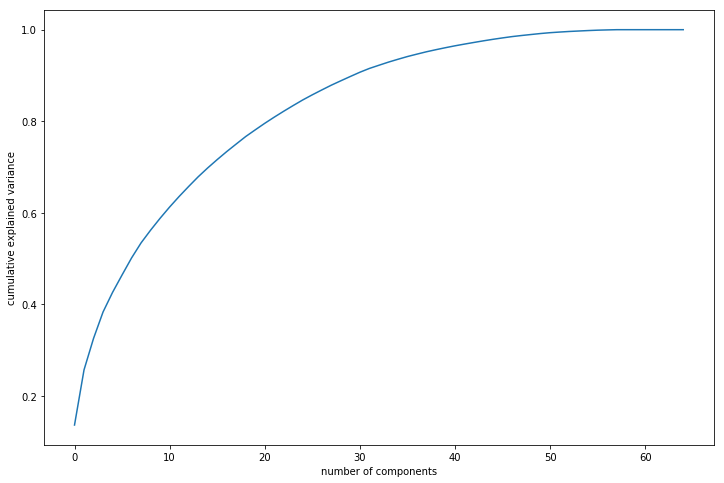

In [531]:
#Plotting the scree plot
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [532]:
dat2.shape

(29953, 65)

In [533]:
colnames = list(dat_churn.drop(['churn'],axis=1).columns)
pcs_df = pd.DataFrame({ 'Feature':colnames})

In [534]:
for x in range(1,36):
    a="PC"+str(x)
    b=pca.components_[x-1]
    pcs_df.insert(loc=x, column=a, value=b)

In [535]:
pcs_df

,Feature,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35
0,arpu_8,-0.035089,0.277250,0.026499,-0.014278,0.228723,-0.018724,0.081460,-0.012219,-0.006040,0.021553,-0.036462,-0.155521,-0.044587,0.069377,0.006269,-0.001254,-0.001147,-0.035507,0.004253,-0.051629,0.061570,0.038304,0.011807,-0.070983,0.008039,-0.047460,0.022197,0.145478,-0.004966,0.024425,0.016890,-0.025194,0.150385,0.214096,-0.143709
1,onnet_mou_8,-0.149504,0.161880,0.101955,0.014656,-0.067702,-0.122513,-0.066659,-0.013558,0.069883,-0.041432,-0.060225,0.037968,0.004710,-0.044926,0.028543,-0.044671,-0.092261,-0.091526,0.137521,0.222955,-0.109435,0.369986,-0.158023,0.400656,0.276624,-0.057009,0.070789,0.174575,-0.018407,0.028715,0.039831,-0.055998,0.048517,0.037389,0.002567
2,offnet_mou_8,-0.144293,0.202586,0.037919,-0.012898,0.017535,-0.085612,-0.040688,-0.009109,0.027689,-0.045596,-0.046870,-0.076492,-0.014198,0.037627,0.002596,-0.004207,0.137431,-0.175248,0.005388,-0.068889,0.210668,-0.318157,0.138176,-0.445029,-0.276618,0.089560,0.031256,-0.077663,-0.004796,0.013011,0.018034,0.005430,0.003801,-0.060592,0.057946
3,roam_ic_mou_8,-0.004373,0.036047,-0.009473,0.087252,0.199918,0.190458,-0.359909,-0.063649,0.056284,0.113590,-0.005738,0.035087,-0.015441,-0.035519,-0.035147,0.018909,-0.017546,0.065750,-0.003111,0.050963,-0.079316,-0.012555,-0.023461,0.101863,-0.267554,0.264015,0.251430,0.174846,0.372556,-0.308967,0.157922,-0.073541,0.063064,-0.010839,-0.075126
4,roam_og_mou_8,-0.021895,0.053029,0.019013,0.109787,0.215833,0.167825,-0.344077,-0.089599,0.074356,0.093114,0.006247,0.014676,-0.007638,-0.011154,0.010216,0.014825,0.006055,0.045731,-0.059834,0.006242,-0.055019,0.009278,-0.033740,-0.010001,-0.187308,0.167105,0.104458,0.437841,-0.422648,0.283722,-0.016461,0.012329,0.000197,-0.083344,0.026144
5,loc_og_mou_8,-0.070180,0.173123,-0.168090,-0.127417,-0.070359,-0.082828,0.024264,-0.270407,0.155610,0.028013,-0.054024,0.022755,0.056349,-0.032499,0.043699,-0.079469,-0.038210,0.073572,0.420881,-0.033651,0.030981,-0.040476,-0.109426,-0.071104,0.012470,-0.007346,0.002617,-0.020299,-0.000829,-0.004992,0.032471,-0.014438,0.018968,0.007730,0.025564
6,std_og_mou_8,-0.180130,0.163279,0.202166,0.058928,-0.057110,-0.144168,-0.062324,0.154572,-0.020199,-0.117710,-0.053975,-0.039251,-0.038155,0.008427,0.004536,0.006448,0.069500,-0.248600,-0.143712,0.119503,0.075155,0.050080,0.061663,-0.011882,0.015824,-0.004564,0.057329,0.009473,0.058025,-0.011169,0.027832,-0.035059,0.036143,0.010173,0.026447
7,isd_og_mou_8,-0.003205,0.077274,-0.003109,0.010910,0.365170,0.085926,0.348158,0.065563,-0.143517,0.197137,-0.119445,-0.057075,0.022494,0.129653,0.005716,0.030665,-0.058420,-0.095062,0.094177,0.140739,0.020998,0.010825,-0.024912,0.075745,-0.024942,0.084595,0.053238,-0.038446,-0.000812,0.004024,0.010728,0.032606,-0.037169,-0.098756,0.129083
8,spl_og_mou_8,-0.040278,0.049837,0.073014,-0.078486,-0.030630,-0.031841,0.003342,0.028831,-0.000316,0.145857,0.447706,-0.190663,-0.156224,-0.053415,-0.364645,-0.039037,-0.154520,-0.148301,0.138696,0.062314,-0.067043,-0.024484,0.040210,0.000677,0.042466,0.055609,-0.075376,0.014165,-0.066915,-0.100461,-0.039586,0.048323,-0.219925,-0.519216,-0.345847
9,og_others_8,-0.003556,0.006990,-0.003071,-0.007536,0.006815,0.024133,0.006513,0.024994,0.080485,0.098047,0.340086,-0.035087,0.053782,0.028936,0.601201,0.032767,0.093349,-0.109400,0.004331,0.099220,0.069046,-0.020455,0.009505,0.044889,0.000986,0.061088,-0.121268,0.053084,-0.263200,-0.515281,-0.311584,-0.044935,0.055562,0.037220,0.030489


In [536]:
#We are observing 90% variance with 35 principal components. So let's take the data until that many components
#Using incremental PCA for efficiency - saves a lot of time on larger datasets
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=35)

In [537]:
#let's project our original data on the 3 principal components
df_train_pca = pca_final.fit_transform(dat2)
df_train_pca.shape

(29953, 35)

In [538]:
#take the transpose of the PC matrix so that we can create the new matrix
pc = np.transpose(df_train_pca)
pc

array([[ 3.23275069,  0.03868773,  0.04713031, ..., -0.63943948,
        -0.20173154,  8.15233626],
       [-1.28494824,  4.81440023, -2.16195185, ...,  3.38858688,
        -0.41001567,  2.13700946],
       [ 0.54196062,  4.24076901, -1.06251347, ...,  3.58424092,
         2.86808987, -1.54530311],
       ...,
       [ 0.31564269,  0.38124347,  0.79945206, ..., -0.54309552,
        -0.58150527, -0.83701543],
       [-0.40702176, -0.26252221,  0.12921537, ...,  0.2655192 ,
        -0.47137891, -0.69587256],
       [ 0.59584242, -5.21288878, -0.26678099, ...,  1.40973385,
         0.21405691,  0.48441428]])

In [539]:
rownames = list(dat_churn['churn'])
pcs_df2 = pd.DataFrame({'churn':rownames})

In [540]:
# to add variable names
for x in range(1,36):
    a="PC"+str(x)
    b=pc[x-1]
    pcs_df2.insert(loc=x, column=a, value=b)

In [541]:
pcs_df2.head()

,churn,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35
0,1,3.232751,-1.284948,0.541961,-2.753694,-0.370263,0.060832,-0.738248,-0.130048,-0.001636,1.152031,0.257618,-0.574845,-0.774930,0.361928,-0.700006,-0.250507,-0.498523,0.044583,0.120397,0.837430,0.584687,-0.003016,-0.541374,-0.276465,0.528594,-1.361716,1.265206,0.361991,-0.297938,0.673927,-0.518999,-0.044374,0.315643,-0.407022,0.595842
1,1,0.038688,4.814400,4.240769,-2.493884,4.613254,-0.060784,-1.640545,-0.357981,0.336193,5.037537,2.338042,-2.102899,-0.115460,-0.949861,0.955391,0.788469,1.686338,-1.598756,-0.085511,-1.244003,-2.776178,1.518745,-1.808737,-1.057533,-0.820281,0.187509,1.739301,-1.234454,0.369378,-1.052092,-0.086725,-1.030216,0.381243,-0.262522,-5.212889
2,0,0.047130,-2.161952,-1.062513,0.355680,-0.052490,0.319437,-0.110027,-0.004624,-0.012523,-0.917351,-0.381178,-0.022378,0.044947,-0.104797,0.670657,-0.298448,0.283969,0.172467,-0.104191,-0.177329,-0.801753,-0.150475,-0.675171,-0.373360,0.089332,0.042825,-0.265973,0.116620,-0.427615,0.691588,0.120522,-0.720879,0.799452,0.129215,-0.266781
3,0,-2.954718,0.280565,-1.652154,-0.003119,-0.822722,-0.426950,-0.147731,0.591065,-0.446078,-0.295694,-1.080093,-0.528501,0.411787,-0.443961,-0.046816,-0.034510,0.165558,-0.483473,0.651874,-1.291547,-0.202333,-0.185545,-0.150032,-1.263968,-0.062012,0.034951,0.278880,0.119954,-0.410508,-0.001642,-0.074264,-0.240378,-0.071101,-0.141273,0.219953
4,0,2.211804,-0.748659,0.120581,-0.638479,-1.282356,-0.608722,-0.253996,0.377789,0.535186,0.198963,-0.193203,-1.080985,0.113697,-0.569688,-1.031994,-0.455536,-0.789880,0.617118,0.174337,0.557511,0.428268,-0.171388,-0.760901,-0.097442,0.661284,-0.233599,-0.238502,0.237836,-0.008235,-0.071936,-0.550269,0.027935,0.095084,-0.330732,-0.004608


### PCA with  Logistic Regression

In [542]:
telecom=pcs_df2
telecom.head()

,churn,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35
0,1,3.232751,-1.284948,0.541961,-2.753694,-0.370263,0.060832,-0.738248,-0.130048,-0.001636,1.152031,0.257618,-0.574845,-0.774930,0.361928,-0.700006,-0.250507,-0.498523,0.044583,0.120397,0.837430,0.584687,-0.003016,-0.541374,-0.276465,0.528594,-1.361716,1.265206,0.361991,-0.297938,0.673927,-0.518999,-0.044374,0.315643,-0.407022,0.595842
1,1,0.038688,4.814400,4.240769,-2.493884,4.613254,-0.060784,-1.640545,-0.357981,0.336193,5.037537,2.338042,-2.102899,-0.115460,-0.949861,0.955391,0.788469,1.686338,-1.598756,-0.085511,-1.244003,-2.776178,1.518745,-1.808737,-1.057533,-0.820281,0.187509,1.739301,-1.234454,0.369378,-1.052092,-0.086725,-1.030216,0.381243,-0.262522,-5.212889
2,0,0.047130,-2.161952,-1.062513,0.355680,-0.052490,0.319437,-0.110027,-0.004624,-0.012523,-0.917351,-0.381178,-0.022378,0.044947,-0.104797,0.670657,-0.298448,0.283969,0.172467,-0.104191,-0.177329,-0.801753,-0.150475,-0.675171,-0.373360,0.089332,0.042825,-0.265973,0.116620,-0.427615,0.691588,0.120522,-0.720879,0.799452,0.129215,-0.266781
3,0,-2.954718,0.280565,-1.652154,-0.003119,-0.822722,-0.426950,-0.147731,0.591065,-0.446078,-0.295694,-1.080093,-0.528501,0.411787,-0.443961,-0.046816,-0.034510,0.165558,-0.483473,0.651874,-1.291547,-0.202333,-0.185545,-0.150032,-1.263968,-0.062012,0.034951,0.278880,0.119954,-0.410508,-0.001642,-0.074264,-0.240378,-0.071101,-0.141273,0.219953
4,0,2.211804,-0.748659,0.120581,-0.638479,-1.282356,-0.608722,-0.253996,0.377789,0.535186,0.198963,-0.193203,-1.080985,0.113697,-0.569688,-1.031994,-0.455536,-0.789880,0.617118,0.174337,0.557511,0.428268,-0.171388,-0.760901,-0.097442,0.661284,-0.233599,-0.238502,0.237836,-0.008235,-0.071936,-0.550269,0.027935,0.095084,-0.330732,-0.004608


In [543]:
from sklearn.model_selection import train_test_split

In [544]:
# Putting feature variable to X
X = telecom.drop(['churn'], axis=1)

X.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35
0,3.232751,-1.284948,0.541961,-2.753694,-0.370263,0.060832,-0.738248,-0.130048,-0.001636,1.152031,0.257618,-0.574845,-0.774930,0.361928,-0.700006,-0.250507,-0.498523,0.044583,0.120397,0.837430,0.584687,-0.003016,-0.541374,-0.276465,0.528594,-1.361716,1.265206,0.361991,-0.297938,0.673927,-0.518999,-0.044374,0.315643,-0.407022,0.595842
1,0.038688,4.814400,4.240769,-2.493884,4.613254,-0.060784,-1.640545,-0.357981,0.336193,5.037537,2.338042,-2.102899,-0.115460,-0.949861,0.955391,0.788469,1.686338,-1.598756,-0.085511,-1.244003,-2.776178,1.518745,-1.808737,-1.057533,-0.820281,0.187509,1.739301,-1.234454,0.369378,-1.052092,-0.086725,-1.030216,0.381243,-0.262522,-5.212889
2,0.047130,-2.161952,-1.062513,0.355680,-0.052490,0.319437,-0.110027,-0.004624,-0.012523,-0.917351,-0.381178,-0.022378,0.044947,-0.104797,0.670657,-0.298448,0.283969,0.172467,-0.104191,-0.177329,-0.801753,-0.150475,-0.675171,-0.373360,0.089332,0.042825,-0.265973,0.116620,-0.427615,0.691588,0.120522,-0.720879,0.799452,0.129215,-0.266781
3,-2.954718,0.280565,-1.652154,-0.003119,-0.822722,-0.426950,-0.147731,0.591065,-0.446078,-0.295694,-1.080093,-0.528501,0.411787,-0.443961,-0.046816,-0.034510,0.165558,-0.483473,0.651874,-1.291547,-0.202333,-0.185545,-0.150032,-1.263968,-0.062012,0.034951,0.278880,0.119954,-0.410508,-0.001642,-0.074264,-0.240378,-0.071101,-0.141273,0.219953
4,2.211804,-0.748659,0.120581,-0.638479,-1.282356,-0.608722,-0.253996,0.377789,0.535186,0.198963,-0.193203,-1.080985,0.113697,-0.569688,-1.031994,-0.455536,-0.789880,0.617118,0.174337,0.557511,0.428268,-0.171388,-0.760901,-0.097442,0.661284,-0.233599,-0.238502,0.237836,-0.008235,-0.071936,-0.550269,0.027935,0.095084,-0.330732,-0.004608


In [545]:
# Putting response variable to y
y = telecom['churn']

y.head()

0    1
1    1
2    0
3    0
4    0
Name: churn, dtype: int64

In [546]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

In [547]:
X_train.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35
5067,-2.609942,1.300426,-0.121840,-2.060065,2.472095,-2.688969,4.249141,0.220665,0.286623,0.088815,-0.769714,-0.812544,0.818125,0.029193,-0.132997,1.390503,-1.124830,1.645879,1.229037,0.030551,1.696111,-1.128105,-0.174304,-1.101126,-2.490975,-2.317738,-2.246668,-3.651407,-0.036571,0.161010,-0.335559,0.325396,0.324261,0.165256,0.433145
25362,-1.200609,-2.213168,-0.008518,-0.880512,-0.919888,-1.238563,-0.409189,0.911561,-0.806082,-0.642080,0.963599,0.150854,0.016888,-0.229146,-0.355350,-0.716016,0.504974,-0.408270,-0.570851,0.056992,-0.381844,-0.153396,-0.654783,-0.083549,0.013198,0.489201,-0.360353,-0.148990,0.230645,-0.521562,-0.019485,0.544772,0.151858,0.797505,-0.061346
10076,0.735374,-3.422890,-1.554569,2.283284,0.828205,-0.048095,0.058833,-0.481036,0.017596,0.515291,-0.800224,-0.842405,-1.653261,0.609989,0.420432,-0.014040,-0.184808,-0.104197,0.286822,0.366648,-0.117546,0.205361,0.009257,-0.097679,0.379799,0.170708,-0.105570,-0.191043,-0.009733,0.284802,0.185477,0.036732,-0.358620,0.222846,0.107320
7679,-4.194188,2.878001,-0.896067,-0.730009,-1.020627,0.816484,-0.250727,0.160095,-0.052037,0.313074,-0.668662,0.716381,-0.143188,0.219048,-0.240223,-0.055503,-0.266920,-1.177423,0.087934,1.093903,-0.149479,1.000236,-1.000864,1.040944,-0.679967,0.179043,0.043143,-0.110808,0.047691,-0.426596,0.112239,-0.038801,-0.120503,-0.009745,-0.527793
14966,2.152891,-2.448449,-0.170465,1.714790,1.588623,4.615819,1.924927,1.559174,-0.211013,-2.096055,1.023390,-0.092044,1.815778,-0.771861,1.420215,-0.712013,0.165429,-0.422835,-1.822033,-1.336055,2.940899,0.773594,-0.951101,-0.385674,-0.144263,-0.151847,-0.348725,0.148364,0.156823,-0.599238,2.277413,-0.857330,0.314680,0.153530,1.464415


In [548]:
### Checking the Churn Rate
churn1 = (sum(telecom['churn'])/len(telecom['churn'].index))*100
churn1

8.122725603445398

In [549]:
pcs_df2.churn.value_counts()

0    27520
1     2433
Name: churn, dtype: int64

In [550]:
y_train.value_counts()

0    19215
1     1752
Name: churn, dtype: int64

In [551]:
telecom.corr()  # Not heavily correlated

,churn,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35
churn,1.000000,-4.236189e-02,-1.359944e-01,-3.807706e-02,-0.196545,-0.005762,-0.158163,-0.017944,0.030015,-0.051050,-0.090349,0.076982,0.213174,-0.075534,0.039938,-0.054463,-0.060531,0.030937,-0.059155,-0.096177,0.086325,0.038723,-0.055344,0.001208,-0.071498,-0.061320,-0.061267,0.048426,0.003715,0.018775,-4.999160e-03,0.009105,-0.020468,0.000741,0.023713,-0.040563
PC1,-0.042362,1.000000e+00,-2.464413e-07,-2.792246e-06,-0.000005,-0.000027,0.000010,0.000025,-0.000027,-0.000047,0.000045,-0.000099,0.000020,0.000049,0.000080,-0.000020,0.000131,-0.000158,-0.000016,-0.000261,-0.000087,-0.000117,0.000083,0.000035,-0.000087,-0.000015,-0.000039,-0.000037,0.000043,0.000011,-2.487618e-07,0.000025,-0.000196,-0.000046,0.000051,-0.000053
PC2,-0.135994,-2.464413e-07,1.000000e+00,-5.781251e-07,0.000008,0.000302,-0.000091,-0.000342,0.000142,0.000038,-0.000254,0.000111,-0.000068,-0.000110,-0.000449,0.000005,-0.000306,0.000176,0.000120,0.000523,0.000370,0.000300,-0.000126,-0.000080,0.000265,0.000030,0.000174,0.000025,-0.000062,0.000075,-1.922516e-04,0.000011,0.000088,-0.000154,0.000622,0.000995
PC3,-0.038077,-2.792246e-06,-5.781251e-07,1.000000e+00,0.000027,-0.000006,-0.000051,0.000005,0.000205,0.000398,0.000074,0.000043,0.000053,-0.000237,-0.000433,0.000071,-0.000111,-0.000101,-0.000040,-0.000033,-0.000044,-0.000038,-0.000100,-0.000085,0.000048,-0.000038,0.000012,-0.000029,0.000042,-0.000018,-6.810726e-05,-0.000063,-0.000616,-0.000328,0.000023,0.000067
PC4,-0.196545,-5.186136e-06,7.525698e-06,2.675268e-05,1.000000,-0.000002,-0.000100,-0.000019,0.000317,0.000633,0.000006,0.000461,0.000024,-0.000368,-0.000722,0.000107,-0.000452,0.000471,-0.000034,0.000727,0.000221,0.000246,-0.000188,-0.000086,0.000193,-0.000056,0.000019,-0.000018,-0.000053,-0.000020,-2.233774e-04,0.000036,0.000358,-0.000032,0.000124,0.000270
PC5,-0.005762,-2.687159e-05,3.023754e-04,-5.573292e-06,-0.000002,1.000000,-0.000642,-0.002872,0.000787,-0.000608,-0.002131,-0.000332,-0.000518,-0.000387,-0.002935,-0.000184,-0.001562,-0.000094,0.001046,0.002284,0.002560,0.001974,-0.000610,-0.000594,0.002022,0.000595,0.001726,0.000842,-0.000800,0.000658,-6.185488e-04,-0.000459,-0.000313,-0.000856,0.004725,0.008083
PC6,-0.158163,1.042051e-05,-9.146598e-05,-5.068113e-05,-0.000100,-0.000642,1.000000,0.000752,-0.000910,-0.001230,0.000574,-0.001155,0.000103,0.000935,0.002242,-0.000194,0.001580,-0.001571,-0.000142,-0.002888,-0.001341,-0.001249,0.000600,0.000290,-0.001079,-0.000030,-0.000459,-0.000048,0.000240,-0.000067,7.087732e-04,0.000075,-0.000689,0.000342,-0.001987,-0.002644
PC7,-0.017944,2.480794e-05,-3.419593e-04,5.195749e-06,-0.000019,-0.002872,0.000752,1.000000,-0.001004,0.000400,0.002390,0.000214,0.000568,0.000527,0.003522,0.000226,0.001801,0.000039,-0.001161,-0.002736,-0.002982,-0.002168,0.000626,0.000602,-0.002252,-0.000628,-0.001916,-0.000911,0.000963,-0.000705,8.031898e-04,0.000393,-0.000174,0.000753,-0.005971,-0.009399
PC8,0.030015,-2.707699e-05,1.420765e-04,2.050012e-04,0.000317,0.000787,-0.000910,-0.001004,1.000000,0.004675,-0.000311,0.002119,0.000171,-0.003093,-0.006592,0.000685,-0.003089,0.001063,-0.000016,0.003788,0.001522,0.001205,-0.001769,-0.000920,0.001718,-0.000369,0.000591,-0.000009,-0.000197,0.000017,-1.671452e-03,-0.000206,-0.000921,-0.001463,0.003251,0.004236
PC9,-0.051050,-4.732395e-05,3.830818e-05,3.984269e-04,0.000633,-0.000608,-0.001230,0.000400,0.004675,1.000000,0.001124,0.005328,0.000791,-0.005901,-0.010896,0.001666,-0.005627,0.003729,-0.001181,0.007685,0.001424,0.001582,-0.003585,-0.001696,0.002134,-0.001355,-0.000248,-0.000999,0.000494,-0.000427,-3.301164e-03,0.000001,-0.003054,-0.003741,0.001512,0.002365


In [552]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
res=logm1.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                20967
Model:                            GLM   Df Residuals:                    20931
Model Family:                Binomial   Df Model:                           35
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3841.6
Date:                Mon, 19 Aug 2019   Deviance:                       7683.2
Time:                        22:13:28   Pearson chi2:                 4.06e+06
No. Iterations:                     9   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.1992      0.080    -52.700      0.000      -4.355      -4.043
PC1           -0.1046      0.022     -4.826      0.000      -0.147      -0.062
PC2           -0.5183      0.023    -22.631      0.000      -0.563      -0.473
PC3           -0.2644      0.037     -7.158      0.000      -0.337      -0.192
PC4           -0.8347      0.037    -22.753      0.000      -0.907      -0.763
PC5           -0.0223      0.026     -0.855      0.393      -0.073       0.029
PC6           -0.3401      0.040     -8.428      0.000      -0.419      -0.261
PC7           -0.2120      0.024     -8.870      0.000      -0.259      -0.165
PC8            0.0123      0.050      0.243      0.808      -0.087       0.111
PC9           -0.1524      0.065     -2.336      0.019      -0.280      -0.025
PC10          -0.1257      0.056     -2.247      0.025      -0.235      -0.016
PC11          -0.3462      0.155     -2.234      0.025      -0.650      -0.042
PC12           0.6515      0.047     13.930      0.000       0.560       0.743
PC13          -0.3325      0.051     -6.492      0.000      -0.433      -0.232
PC14           0.3128      0.062      5.054      0.000       0.191       0.434
PC15          -0.4859      0.108     -4.494      0.000      -0.698      -0.274
PC16          -0.0593      0.131     -0.451      0.652      -0.317       0.198
PC17          -1.0086      0.273     -3.690      0.000      -1.544      -0.473
PC18          -0.1248      0.077     -1.631      0.103      -0.275       0.025
PC19          -0.9802      0.335     -2.926      0.003      -1.637      -0.324
PC20          -0.0283      0.122     -0.232      0.816      -0.267       0.210
PC21          -1.0028      0.222     -4.526      0.000      -1.437      -0.569
PC22           0.1840      0.088      2.099      0.036       0.012       0.356
PC23          -0.0328      0.057     -0.574      0.566      -0.145       0.079
PC24          -0.7250      0.098     -7.370      0.000      -0.918      -0.532
PC25          -0.0325      0.064     -0.509      0.610      -0.157       0.092
PC26           0.1428      0.066      2.169      0.030       0.014       0.272
PC27           0.2184      0.062      3.504      0.000       0.096       0.341
PC28          -0.1093      0.040     -2.754      0.006      -0.187      -0.032
PC29           0.0033      0.031      0.107      0.915      -0.057       0.063
PC30           0.5015      0.077      6.487      0.000       0.350       0.653
PC31           0.4608      0.070      6.621      0.000       0.324       0.597
PC32           0.9656      0.353      2.735      0.006       0.274       1.658
PC33           0.3600      0.159      2.259      0.024       0.048       0.672
PC34           0.8758      0.071     12.299      0.000       0.736       1.015
PC35          -0.6537      0.072     -9.068      0.000      -0.795      -0.512
==============================================================================
""

In [553]:
from sklearn.feature_selection import RFE
# Getting the predicted values on the train set
y_train_pred = res.predict(sm.add_constant(X_train))
y_train_pred[:10]

5067     0.006763
25362    0.512312
10076    0.031797
7679     0.025861
14966    0.000054
27690    0.003099
6262     0.078437
1424     0.019780
18887    0.000498
21093    0.000003
dtype: float64

In [554]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([6.76250034e-03, 5.12311956e-01, 3.17968646e-02, 2.58607822e-02,
       5.37478898e-05, 3.09891145e-03, 7.84365577e-02, 1.97795701e-02,
       4.98492956e-04, 2.58680346e-06])

In [555]:
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final['CustID'] = y_train.index
y_train_pred_final.head()

,Churn,Churn_Prob,CustID
0,0,0.006763,5067
1,0,0.512312,25362
2,0,0.031797,10076
3,0,0.025861,7679
4,0,0.000054,14966


In [556]:
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,Churn,Churn_Prob,CustID,predicted
0,0,0.006763,5067,0
1,0,0.512312,25362,1
2,0,0.031797,10076,0
3,0,0.025861,7679,0
4,0,0.000054,14966,0


In [557]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
print(confusion)

[[18960   255]
 [ 1216   536]]


In [558]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

0.929842132875471


In [559]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [560]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.3059360730593607

In [561]:
# Let us calculate specificity
TN / float(TN+FP)

0.9867291178766588

In [562]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.01327088212334114


In [563]:
# positive predictive value 
print (TP / float(TP+FP))

0.6776232616940582


In [564]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9397303727200634


In [565]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [566]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Churn, y_train_pred_final.Churn_Prob, drop_intermediate = False )

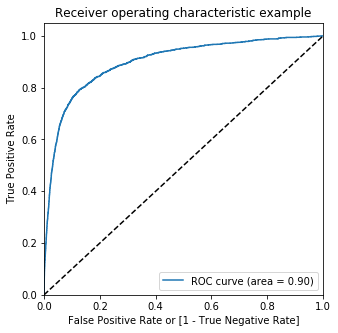

In [567]:
draw_roc(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)

ROC Curve of 0.89 is a good model

### Feature selection using RFE and class imbalance

In [568]:
telecom1=pcs_df2
telecom1.head()

,churn,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35
0,1,3.232751,-1.284948,0.541961,-2.753694,-0.370263,0.060832,-0.738248,-0.130048,-0.001636,1.152031,0.257618,-0.574845,-0.774930,0.361928,-0.700006,-0.250507,-0.498523,0.044583,0.120397,0.837430,0.584687,-0.003016,-0.541374,-0.276465,0.528594,-1.361716,1.265206,0.361991,-0.297938,0.673927,-0.518999,-0.044374,0.315643,-0.407022,0.595842
1,1,0.038688,4.814400,4.240769,-2.493884,4.613254,-0.060784,-1.640545,-0.357981,0.336193,5.037537,2.338042,-2.102899,-0.115460,-0.949861,0.955391,0.788469,1.686338,-1.598756,-0.085511,-1.244003,-2.776178,1.518745,-1.808737,-1.057533,-0.820281,0.187509,1.739301,-1.234454,0.369378,-1.052092,-0.086725,-1.030216,0.381243,-0.262522,-5.212889
2,0,0.047130,-2.161952,-1.062513,0.355680,-0.052490,0.319437,-0.110027,-0.004624,-0.012523,-0.917351,-0.381178,-0.022378,0.044947,-0.104797,0.670657,-0.298448,0.283969,0.172467,-0.104191,-0.177329,-0.801753,-0.150475,-0.675171,-0.373360,0.089332,0.042825,-0.265973,0.116620,-0.427615,0.691588,0.120522,-0.720879,0.799452,0.129215,-0.266781
3,0,-2.954718,0.280565,-1.652154,-0.003119,-0.822722,-0.426950,-0.147731,0.591065,-0.446078,-0.295694,-1.080093,-0.528501,0.411787,-0.443961,-0.046816,-0.034510,0.165558,-0.483473,0.651874,-1.291547,-0.202333,-0.185545,-0.150032,-1.263968,-0.062012,0.034951,0.278880,0.119954,-0.410508,-0.001642,-0.074264,-0.240378,-0.071101,-0.141273,0.219953
4,0,2.211804,-0.748659,0.120581,-0.638479,-1.282356,-0.608722,-0.253996,0.377789,0.535186,0.198963,-0.193203,-1.080985,0.113697,-0.569688,-1.031994,-0.455536,-0.789880,0.617118,0.174337,0.557511,0.428268,-0.171388,-0.760901,-0.097442,0.661284,-0.233599,-0.238502,0.237836,-0.008235,-0.071936,-0.550269,0.027935,0.095084,-0.330732,-0.004608


In [569]:
from sklearn.model_selection import train_test_split

In [570]:
# Putting feature variable to X
X = telecom1.drop(['churn'], axis=1)

X.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35
0,3.232751,-1.284948,0.541961,-2.753694,-0.370263,0.060832,-0.738248,-0.130048,-0.001636,1.152031,0.257618,-0.574845,-0.774930,0.361928,-0.700006,-0.250507,-0.498523,0.044583,0.120397,0.837430,0.584687,-0.003016,-0.541374,-0.276465,0.528594,-1.361716,1.265206,0.361991,-0.297938,0.673927,-0.518999,-0.044374,0.315643,-0.407022,0.595842
1,0.038688,4.814400,4.240769,-2.493884,4.613254,-0.060784,-1.640545,-0.357981,0.336193,5.037537,2.338042,-2.102899,-0.115460,-0.949861,0.955391,0.788469,1.686338,-1.598756,-0.085511,-1.244003,-2.776178,1.518745,-1.808737,-1.057533,-0.820281,0.187509,1.739301,-1.234454,0.369378,-1.052092,-0.086725,-1.030216,0.381243,-0.262522,-5.212889
2,0.047130,-2.161952,-1.062513,0.355680,-0.052490,0.319437,-0.110027,-0.004624,-0.012523,-0.917351,-0.381178,-0.022378,0.044947,-0.104797,0.670657,-0.298448,0.283969,0.172467,-0.104191,-0.177329,-0.801753,-0.150475,-0.675171,-0.373360,0.089332,0.042825,-0.265973,0.116620,-0.427615,0.691588,0.120522,-0.720879,0.799452,0.129215,-0.266781
3,-2.954718,0.280565,-1.652154,-0.003119,-0.822722,-0.426950,-0.147731,0.591065,-0.446078,-0.295694,-1.080093,-0.528501,0.411787,-0.443961,-0.046816,-0.034510,0.165558,-0.483473,0.651874,-1.291547,-0.202333,-0.185545,-0.150032,-1.263968,-0.062012,0.034951,0.278880,0.119954,-0.410508,-0.001642,-0.074264,-0.240378,-0.071101,-0.141273,0.219953
4,2.211804,-0.748659,0.120581,-0.638479,-1.282356,-0.608722,-0.253996,0.377789,0.535186,0.198963,-0.193203,-1.080985,0.113697,-0.569688,-1.031994,-0.455536,-0.789880,0.617118,0.174337,0.557511,0.428268,-0.171388,-0.760901,-0.097442,0.661284,-0.233599,-0.238502,0.237836,-0.008235,-0.071936,-0.550269,0.027935,0.095084,-0.330732,-0.004608


In [571]:
# Putting response variable to y
y = telecom1['churn']

y.head()

0    1
1    1
2    0
3    0
4    0
Name: churn, dtype: int64

In [572]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

In [573]:
X_train.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35
5067,-2.609942,1.300426,-0.121840,-2.060065,2.472095,-2.688969,4.249141,0.220665,0.286623,0.088815,-0.769714,-0.812544,0.818125,0.029193,-0.132997,1.390503,-1.124830,1.645879,1.229037,0.030551,1.696111,-1.128105,-0.174304,-1.101126,-2.490975,-2.317738,-2.246668,-3.651407,-0.036571,0.161010,-0.335559,0.325396,0.324261,0.165256,0.433145
25362,-1.200609,-2.213168,-0.008518,-0.880512,-0.919888,-1.238563,-0.409189,0.911561,-0.806082,-0.642080,0.963599,0.150854,0.016888,-0.229146,-0.355350,-0.716016,0.504974,-0.408270,-0.570851,0.056992,-0.381844,-0.153396,-0.654783,-0.083549,0.013198,0.489201,-0.360353,-0.148990,0.230645,-0.521562,-0.019485,0.544772,0.151858,0.797505,-0.061346
10076,0.735374,-3.422890,-1.554569,2.283284,0.828205,-0.048095,0.058833,-0.481036,0.017596,0.515291,-0.800224,-0.842405,-1.653261,0.609989,0.420432,-0.014040,-0.184808,-0.104197,0.286822,0.366648,-0.117546,0.205361,0.009257,-0.097679,0.379799,0.170708,-0.105570,-0.191043,-0.009733,0.284802,0.185477,0.036732,-0.358620,0.222846,0.107320
7679,-4.194188,2.878001,-0.896067,-0.730009,-1.020627,0.816484,-0.250727,0.160095,-0.052037,0.313074,-0.668662,0.716381,-0.143188,0.219048,-0.240223,-0.055503,-0.266920,-1.177423,0.087934,1.093903,-0.149479,1.000236,-1.000864,1.040944,-0.679967,0.179043,0.043143,-0.110808,0.047691,-0.426596,0.112239,-0.038801,-0.120503,-0.009745,-0.527793
14966,2.152891,-2.448449,-0.170465,1.714790,1.588623,4.615819,1.924927,1.559174,-0.211013,-2.096055,1.023390,-0.092044,1.815778,-0.771861,1.420215,-0.712013,0.165429,-0.422835,-1.822033,-1.336055,2.940899,0.773594,-0.951101,-0.385674,-0.144263,-0.151847,-0.348725,0.148364,0.156823,-0.599238,2.277413,-0.857330,0.314680,0.153530,1.464415


In [574]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(class_weight='balanced')

In [575]:
from sklearn.feature_selection import RFE
rfe = RFE(logreg, 15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)

In [576]:
rfe.support_

array([False,  True,  True,  True, False,  True, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True, False,
        True, False,  True, False, False,  True, False, False, False,
       False, False, False, False, False, False,  True,  True])

In [577]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('PC1', False, 11),
 ('PC2', True, 1),
 ('PC3', True, 1),
 ('PC4', True, 1),
 ('PC5', False, 19),
 ('PC6', True, 1),
 ('PC7', False, 9),
 ('PC8', False, 5),
 ('PC9', False, 7),
 ('PC10', False, 8),
 ('PC11', False, 16),
 ('PC12', True, 1),
 ('PC13', True, 1),
 ('PC14', True, 1),
 ('PC15', True, 1),
 ('PC16', True, 1),
 ('PC17', True, 1),
 ('PC18', False, 14),
 ('PC19', True, 1),
 ('PC20', False, 10),
 ('PC21', True, 1),
 ('PC22', False, 12),
 ('PC23', False, 15),
 ('PC24', True, 1),
 ('PC25', False, 18),
 ('PC26', False, 20),
 ('PC27', False, 6),
 ('PC28', False, 21),
 ('PC29', False, 17),
 ('PC30', False, 3),
 ('PC31', False, 2),
 ('PC32', False, 4),
 ('PC33', False, 13),
 ('PC34', True, 1),
 ('PC35', True, 1)]

In [578]:
col = X_train.columns[rfe.support_]

In [579]:
X_train.columns[~rfe.support_]

Index(['PC1', 'PC5', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC18', 'PC20', 'PC22', 'PC23', 'PC25', 'PC26', 'PC27', 'PC28', 'PC29', 'PC30', 'PC31', 'PC32', 'PC33'], dtype='object')

In [580]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                20967
Model:                            GLM   Df Residuals:                    20951
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3969.9
Date:                Mon, 19 Aug 2019   Deviance:                       7939.9
Time:                        22:13:35   Pearson chi2:                 3.21e+05
No. Iterations:                     8   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9314      0.064    -61.903      0.000      -4.056      -3.807
PC2           -0.5444      0.020    -26.564      0.000      -0.585      -0.504
PC3           -0.3256      0.029    -11.349      0.000      -0.382      -0.269
PC4           -0.6961      0.027    -25.816      0.000      -0.749      -0.643
PC6           -0.2678      0.024    -11.098      0.000      -0.315      -0.221
PC12           0.6464      0.029     22.259      0.000       0.589       0.703
PC13          -0.2567      0.034     -7.595      0.000      -0.323      -0.190
PC14           0.2997      0.041      7.264      0.000       0.219       0.381
PC15          -0.2427      0.046     -5.278      0.000      -0.333      -0.153
PC16          -0.3615      0.058     -6.273      0.000      -0.475      -0.249
PC17          -0.0648      0.070     -0.925      0.355      -0.202       0.073
PC19          -0.3984      0.065     -6.117      0.000      -0.526      -0.271
PC21          -0.5059      0.066     -7.678      0.000      -0.635      -0.377
PC24          -0.5397      0.055     -9.864      0.000      -0.647      -0.432
PC34           0.7114      0.061     11.571      0.000       0.591       0.832
PC35          -0.5392      0.054     -9.897      0.000      -0.646      -0.432
==============================================================================
"""

Checking VIFs

In [581]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [582]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
8,PC16,1.03
9,PC17,1.02
6,PC14,1.01
7,PC15,1.01
10,PC19,1.01
12,PC24,1.01
0,PC2,1.00
1,PC3,1.00
2,PC4,1.00
3,PC6,1.00


In [583]:
y_train_pred = res.predict(sm.add_constant(X_train_sm))
y_train_pred[:10]

5067     0.011674
25362    0.407063
10076    0.044695
7679     0.010995
14966    0.000856
27690    0.010239
6262     0.058183
1424     0.029929
18887    0.001450
21093    0.000002
dtype: float64

In [584]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([1.16736526e-02, 4.07062679e-01, 4.46949884e-02, 1.09947164e-02,
       8.56308241e-04, 1.02390160e-02, 5.81831919e-02, 2.99293765e-02,
       1.45013191e-03, 1.65372413e-06])

In [585]:
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final['CustID'] = y_train.index
y_train_pred_final.head()

,Churn,Churn_Prob,CustID
0,0,0.011674,5067
1,0,0.407063,25362
2,0,0.044695,10076
3,0,0.010995,7679
4,0,0.000856,14966


In [586]:
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,Churn,Churn_Prob,CustID,predicted
0,0,0.011674,5067,0
1,0,0.407063,25362,0
2,0,0.044695,10076,0
3,0,0.010995,7679,0
4,0,0.000856,14966,0


In [587]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
print(confusion)

[[18955   260]
 [ 1271   481]]


In [588]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

0.9269804931559117


In [589]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [590]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.2745433789954338

In [591]:
# Let us calculate specificity
TN / float(TN+FP)

0.9864689045016913

In [592]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.013531095498308613


In [593]:
# positive predictive value 
print (TP / float(TP+FP))

0.6491228070175439


In [594]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9371600909720162


In [595]:
# ROC function

def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [596]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Churn, y_train_pred_final.Churn_Prob, drop_intermediate = False )

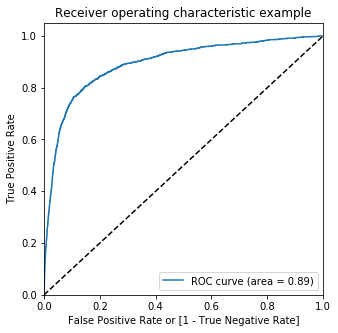

In [597]:
# Import matplotlib to plot the ROC curve

import matplotlib.pyplot as plt
# Call the ROC function

draw_roc(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)

In [598]:
# Let's create columns with different probability cutoffs 

numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,CustID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.011674,5067,0,1,0,0,0,0,0,0,0,0,0
1,0,0.407063,25362,0,1,1,1,1,1,0,0,0,0,0
2,0,0.044695,10076,0,1,0,0,0,0,0,0,0,0,0
3,0,0.010995,7679,0,1,0,0,0,0,0,0,0,0,0
4,0,0.000856,14966,0,1,0,0,0,0,0,0,0,0,0


In [599]:
# Let's create a dataframe to see the values of accuracy, sensitivity, and specificity at different values of probabiity cutoffs

cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.083560  1.000000  0.000000
0.1   0.1  0.841847  0.808219  0.844913
0.2   0.2  0.911051  0.670662  0.932969
0.3   0.3  0.924882  0.527968  0.961072
0.4   0.4  0.926885  0.388699  0.975956
0.5   0.5  0.926980  0.274543  0.986469
0.6   0.6  0.926074  0.199201  0.992350
0.7   0.7  0.924262  0.136986  0.996045
0.8   0.8  0.921400  0.077055  0.998387
0.9   0.9  0.918300  0.028539  0.999428


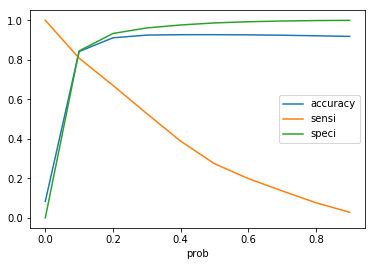

In [600]:
# Let's plot it as well

cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

From above it can be seen that optimal point can be aound 0.13

In [601]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.13 else 0)

y_train_pred_final.head()

,Churn,Churn_Prob,CustID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.011674,5067,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0.407063,25362,0,1,1,1,1,1,0,0,0,0,0,1
2,0,0.044695,10076,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.010995,7679,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0.000856,14966,0,1,0,0,0,0,0,0,0,0,0,0


In [602]:
# Let's check the accuracy now

metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.final_predicted)

0.87599561215243

In [603]:
# Let's create the confusion matrix once again

confusion2 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.final_predicted )
confusion2

array([[17022,  2193],
       [  407,  1345]], dtype=int64)

In [604]:
# Let's evaluate the other metrics as well

TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [605]:
# Calculate Sensitivity

TP/(TP+FN)

0.7676940639269406

In [606]:
# Calculate Specificity

TN/(TN+FP)

0.8858704137392662

### On Test Set

In [607]:
X_test = X_test[col]

In [608]:
# Add a constant to X_test

X_test_sm = sm.add_constant(X_test[col])

In [609]:
# Make predictions on the test set and store it in the variable 'y_test_pred'

y_test_pred = res.predict(X_test_sm)

In [610]:
y_test_pred[:10]

14483    0.000508
8922     0.002805
15014    0.004904
19846    0.009731
27504    0.028648
17053    0.000036
1032     0.002298
14634    0.000437
10314    0.000878
18995    0.000275
dtype: float64

In [611]:
# Converting y_pred to a dataframe

y_pred_1 = pd.DataFrame(y_test_pred)

In [612]:
# Let's see the head

y_pred_1.head()

,0
14483,0.000508
8922,0.002805
15014,0.004904
19846,0.009731
27504,0.028648


In [613]:
# Converting y_test to dataframe

y_test_df = pd.DataFrame(y_test)

In [614]:
# Remove index for both dataframes to append them side by side 

y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [615]:
# Append y_test_df and y_pred_1

y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

In [616]:
# Check 'y_pred_final'

y_pred_final.head()

,churn,0
0,0,0.000508
1,0,0.002805
2,0,0.004904
3,0,0.009731
4,0,0.028648


In [617]:
# Rename the column 

y_pred_final= y_pred_final.rename(columns = {0 : 'Conversion_Prob'})

In [618]:
# Let's see the head of y_pred_final

y_pred_final.head()

,churn,Conversion_Prob
0,0,0.000508
1,0,0.002805
2,0,0.004904
3,0,0.009731
4,0,0.028648


In [619]:
# Make predictions on the test set using 0.45 as the cutoff

y_pred_final['final_predicted'] = y_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.13 else 0)

In [620]:
# Check y_pred_final

y_pred_final.head()

,churn,Conversion_Prob,final_predicted
0,0,0.000508,0
1,0,0.002805,0
2,0,0.004904,0
3,0,0.009731,0
4,0,0.028648,0


In [621]:
# Let's check the overall accuracy

metrics.accuracy_score(y_pred_final['churn'], y_pred_final.final_predicted)

0.8746939683952816

In [622]:
confusion2 = metrics.confusion_matrix(y_pred_final['churn'], y_pred_final.final_predicted )
confusion2

array([[7339,  966],
       [ 160,  521]], dtype=int64)

In [623]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [624]:
# Calculate sensitivity
TP / float(TP+FN)

0.7650513950073421

In [625]:
# Calculate specificity
TN / float(TN+FP)

0.8836845273931366

Accuracy, Sensitivity and Specificity are more than 75%, lets conclude the best model by doing Random Forest as well

### RandomForests

In [626]:
df=churnDataHighEndCust
df.head()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,total_og_mou_8,loc_ic_mou_8,std_ic_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,max_rech_amt_8,last_day_rch_amt_8,vol_2g_mb_8,vol_3g_mb_8,arpu_3g_8,arpu_2g_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,fb_user_8,aon,aug_vbc_3g,sep_vbc_3g,DaysFromLastRech,rech_amt_8,churn,Avg67_arpu,Avg67_roam_ic_mou,Avg67_roam_og_mou,Avg67_loc_og_mou,Avg67_std_og_mou,Avg67_isd_og_mou,Avg67_spl_og_mou,Avg67_og_others,Avg67_total_og_mou,Avg67_loc_ic_mou,Avg67_std_ic_mou,Avg67_total_ic_mou,Avg67_spl_ic_mou,Avg67_isd_ic_mou,Avg67_ic_others,Avg67_total_rech_num,Avg67_max_rech_amt,Avg67_last_day_rch_amt,Avg67_vol_2g_mb,Avg67_vol_3g_mb,Avg67_arpu_3g,Avg67_arpu_2g,Avg67_monthly_2g,Avg67_sachet_2g,Avg67_monthly_3g,Avg67_sachet_3g,Avg67_fb_user,Avg67_rech_amt,Avg67_mou,mou_8,Avg67_vbc_3g
0,213.803,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,5.44,0.00,5.44,0.0,0.00,0.00,2,252,252,5.75,109.61,212.17,212.17,0,0,1,0,1.0,968,30.40,3.58,54,504.0,1,206.1005,0.00,0.000,0.000,0.000,0.000,0.00,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.5,252.0,252.0,15.725,117.165,212.170,212.17,0.0,0.0,1.0,0.0,1.0,559.0,0.000,0.00,50.600
7,3171.480,52.29,325.91,31.64,38.06,255.79,77.84,10.01,6.50,0.0,350.16,188.04,193.94,428.74,0.0,31.59,15.14,7,1580,779,0.00,0.00,0.00,0.00,0,0,0,0,0.0,802,57.74,0.00,36,3638.0,1,1209.5150,24.86,18.165,478.035,68.000,0.090,2.25,0.0,548.385,391.555,176.810,592.250,0.105,8.295,15.465,5.0,1185.0,0.0,0.000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,1185.0,566.555,378.20,19.060
8,137.362,35.08,136.48,0.00,0.00,63.04,98.28,0.00,10.23,0.0,171.56,15.79,0.75,16.54,0.0,0.00,0.00,14,30,10,0.03,11.94,19.83,0.00,0,3,0,0,1.0,315,21.03,0.00,32,327.0,0,435.4720,0.00,0.000,333.135,136.870,0.000,0.00,0.0,470.010,52.630,13.545,66.175,0.000,0.000,0.000,20.0,122.0,25.0,178.000,375.475,0.000,0.00,0.5,0.5,0.0,0.0,0.5,696.0,470.005,171.56,516.405
21,637.760,85.14,983.39,0.00,0.00,129.74,938.79,0.00,0.00,0.0,1068.54,159.11,101.93,261.04,0.0,0.00,0.00,27,50,50,0.00,0.00,0.00,0.00,0,0,0,0,0.0,720,0.00,0.00,31,718.0,0,556.1030,0.00,0.000,95.565,848.990,0.000,0.00,0.0,944.565,106.505,62.985,169.490,0.000,0.000,0.000,24.0,50.0,25.0,0.000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,640.0,944.565,1068.53,0.000
23,366.966,33.58,205.89,0.00,0.00,182.14,39.61,0.00,17.71,0.0,239.48,224.21,57.29,298.33,0.0,3.74,13.06,4,179,0,0.01,1009.92,197.27,150.67,0,0,1,1,1.0,604,40.45,0.00,38,979.0,0,134.1235,0.00,0.000,132.795,4.355,0.005,0.05,0.0,137.210,145.520,8.915,171.235,0.000,14.115,2.675,4.0,89.5,89.5,0.240,299.545,153.285,150.89,0.0,0.0,1.0,0.0,0.5,583.0,137.195,239.47,25.930


In [627]:
# Putting feature variable to X
X = df.drop('churn',axis=1)

# Putting response variable to y
y = df['churn']

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [628]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters.
rfc = RandomForestClassifier()

In [629]:
# fit
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [630]:
# Making predictions
predictions = rfc.predict(X_test)

In [631]:
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

In [632]:
# Let's check the report of our default model
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      8237
           1       0.72      0.44      0.54       749

    accuracy                           0.94      8986
   macro avg       0.84      0.71      0.76      8986
weighted avg       0.93      0.94      0.93      8986



In [633]:
# Printing confusion matrix
print(confusion_matrix(y_test,predictions))

[[8112  125]
 [ 422  327]]


In [634]:
confusion=confusion_matrix(y_test,predictions)

In [635]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [636]:
print(accuracy_score(y_test,predictions))

0.9391275317160027


In [637]:
# Let's see the sensitivity of our Random forests regression model
TP / float(TP+FN)

0.43658210947930576

In [638]:
# Let us calculate specificity
TN / float(TN+FP)

0.984824572052932

Sensitivity is around 45%. Lets see after tuning the parameters

In [639]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,8,10],
    'min_samples_leaf': range(100, 400, 200),
    'min_samples_split': range(200, 500, 200),
    'n_estimators': [100,200, 300], 
    'max_features': [5, 10]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1,verbose = 1)

In [640]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  4.4min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [641]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.9441980254685935 using {'max_depth': 4, 'max_features': 10, 'min_samples_leaf': 100, 'min_samples_split': 400, 'n_estimators': 300}


In [642]:
# model with the best hyperparameters
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=8,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=10,
                             n_estimators=100)

In [643]:
# fit
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features=10, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=200,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [644]:
# predict
predictions = rfc.predict(X_test)

In [645]:
# evaluation metrics
from sklearn.metrics import classification_report,confusion_matrix

In [646]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      8237
           1       0.73      0.44      0.55       749

    accuracy                           0.94      8986
   macro avg       0.84      0.71      0.76      8986
weighted avg       0.93      0.94      0.93      8986



In [647]:
print(confusion_matrix(y_test,predictions))

confusion =confusion_matrix(y_test,predictions)

[[8112  125]
 [ 419  330]]


In [648]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [649]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.44058744993324434

In [650]:
# Let us calculate specificity
TN / float(TN+FP)

0.984824572052932

After analysing both logistic regression and Random forests. Logistic  Regression got better Accuracy, Sensitivty and Specificity compared to Random forests even after fine tuning.

#Model using Logistics Regression to find out the top features impacting the Churn 

In [651]:
X = churnDataHighEndCust.copy(deep=True)

y = churnDataHighEndCust['churn']

X.drop(['churn'],axis=1, inplace=True)

In [652]:
churnData.filter(like='date').columns

Index(['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9', 'date_of_last_rech_9', 'date_of_last_rech_data_9'], dtype='object')

In [653]:
# scaling the features
from sklearn.preprocessing import scale

# storing column names in cols, since column names are (annoyingly) lost after 
# scaling (the df is converted to a numpy array)
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X.columns

Index(['arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8', 'roam_og_mou_8', 'loc_og_mou_8', 'std_og_mou_8', 'isd_og_mou_8', 'spl_og_mou_8', 'og_others_8', 'total_og_mou_8', 'loc_ic_mou_8', 'std_ic_mou_8', 'total_ic_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8', 'total_rech_num_8', 'max_rech_amt_8', 'last_day_rch_amt_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'arpu_3g_8', 'arpu_2g_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'fb_user_8', 'aon', 'aug_vbc_3g', 'sep_vbc_3g', 'DaysFromLastRech', 'rech_amt_8', 'Avg67_arpu', 'Avg67_roam_ic_mou', 'Avg67_roam_og_mou', 'Avg67_loc_og_mou', 'Avg67_std_og_mou', 'Avg67_isd_og_mou', 'Avg67_spl_og_mou', 'Avg67_og_others', 'Avg67_total_og_mou', 'Avg67_loc_ic_mou', 'Avg67_std_ic_mou', 'Avg67_total_ic_mou', 'Avg67_spl_ic_mou', 'Avg67_isd_ic_mou', 'Avg67_ic_others', 'Avg67_total_rech_num', 'Avg67_max_rech_amt', 'Avg67_last_day_rch_amt', 'Avg67_vol_2g_mb', 'Avg67_vol_3g_mb', 'Avg67_arpu_3g', 'Avg67_arpu_2g', 'Avg67_monthly_2g',
  

In [654]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

In [655]:
X.shape

(29953, 65)

In [656]:
print(y_train.shape)
X_train.shape

(20967,)


(20967, 65)

In [657]:
y_train.head()

16686    0
84709    0
33699    0
25535    0
49976    0
Name: churn, dtype: int64

In [658]:
#Check with different models on this DF
#Logistics Regression
#Model building
import statsmodels.api as sm

In [659]:
# Logistic regression model

y_train = list(y_train)
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial(), class_weight = {0:0.1, 1: 0.9})
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                20967
Model:                            GLM   Df Residuals:                    20902
Model Family:                Binomial   Df Model:                           64
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3708.6
Date:                Mon, 19 Aug 2019   Deviance:                       7417.2
Time:                        22:18:23   Pearson chi2:                 4.11e+05
No. Iterations:                   100   Covariance Type:             nonrobust
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -4.3330      0.100    -43.236      0.000      -4.529      -4.137
arpu_8                    -0.1492      0.129     -1.159      0.246      -0.401       0.103
onnet_mou_8               -0.3524      1.434     -0.246      0.806      -3.162       2.457
offnet_mou_8              -0.3526      1.503     -0.235      0.815      -3.299       2.594
roam_ic_mou_8             -0.0209      0.033     -0.644      0.519      -0.085       0.043
roam_og_mou_8              0.1494      0.618      0.242      0.809      -1.062       1.361
loc_og_mou_8            8086.8332   2143.096      3.773      0.000    3886.441    1.23e+04
std_og_mou_8            1.355e+04   3590.664      3.774      0.000    6512.024    2.06e+04
isd_og_mou_8             995.0811    263.789      3.772      0.000     478.064    1512.098
spl_og_mou_8             451.3327    119.612      3.773      0.000     216.897     685.769
og_others_8               71.0919     19.807      3.589      0.000      32.270     109.914
total_og_mou_8         -1.558e+04   4129.888     -3.773      0.000   -2.37e+04   -7489.594
loc_ic_mou_8            1.433e+04   1927.232      7.437      0.000    1.06e+04    1.81e+04
std_ic_mou_8            6453.5497    867.624      7.438      0.000    4753.039    8154.061
total_ic_mou_8         -1.679e+04   2257.530     -7.439      0.000   -2.12e+04   -1.24e+04
spl_ic_mou_8               4.4915      0.710      6.329      0.000       3.101       5.882
isd_ic_mou_8            3283.4330    441.416      7.438      0.000    2418.273    4148.593
ic_others_8              594.6416     79.928      7.440      0.000     437.986     751.297
total_rech_num_8          -0.0753      0.072     -1.051      0.293      -0.216       0.065
max_rech_amt_8             0.2107      0.055      3.832      0.000       0.103       0.319
last_day_rch_amt_8        -0.3787      0.055     -6.909      0.000      -0.486      -0.271
vol_2g_mb_8               -0.2589      0.082     -3.159      0.002      -0.420      -0.098
vol_3g_mb_8               -0.0887      0.102     -0.873      0.383      -0.288       0.110
arpu_3g_8                 -0.0065      0.178     -0.036      0.971      -0.355       0.342
arpu_2g_8                  0.0406      0.187      0.218      0.828      -0.325       0.406
monthly_2g_8              -0.2282      0.089     -2.574      0.010      -0.402      -0.054
sachet_2g_8               -0.4769      0.116     -4.099      0.000      -0.705      -0.249
monthly_3g_8              -0.1954      0.129     -1.511      0.131      -0.449       0.058
sachet_3g_8               -0.2404      0.110     -2.192      0.028      -0.455      -0.025
fb_user_8                 -0.3294      0.075     -4.417      0.000      -0.476      -0.183
aon                       -0.2778      0.040     -6.914      0.000      -0.357      -0.199
aug_vbc_3g                -0.3247      0.088     -3.674      0.000  

In [660]:
#Feature selection using RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [661]:
from sklearn.feature_selection import RFE
rfe = RFE(logreg, 30)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)

In [662]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('arpu_8', True, 1),
 ('onnet_mou_8', False, 19),
 ('offnet_mou_8', False, 18),
 ('roam_ic_mou_8', False, 33),
 ('roam_og_mou_8', False, 20),
 ('loc_og_mou_8', True, 1),
 ('std_og_mou_8', False, 30),
 ('isd_og_mou_8', True, 1),
 ('spl_og_mou_8', False, 27),
 ('og_others_8', True, 1),
 ('total_og_mou_8', True, 1),
 ('loc_ic_mou_8', True, 1),
 ('std_ic_mou_8', False, 32),
 ('total_ic_mou_8', True, 1),
 ('spl_ic_mou_8', True, 1),
 ('isd_ic_mou_8', True, 1),
 ('ic_others_8', False, 2),
 ('total_rech_num_8', False, 21),
 ('max_rech_amt_8', True, 1),
 ('last_day_rch_amt_8', True, 1),
 ('vol_2g_mb_8', True, 1),
 ('vol_3g_mb_8', False, 14),
 ('arpu_3g_8', False, 36),
 ('arpu_2g_8', False, 26),
 ('monthly_2g_8', True, 1),
 ('sachet_2g_8', True, 1),
 ('monthly_3g_8', True, 1),
 ('sachet_3g_8', True, 1),
 ('fb_user_8', True, 1),
 ('aon', True, 1),
 ('aug_vbc_3g', True, 1),
 ('sep_vbc_3g', True, 1),
 ('DaysFromLastRech', True, 1),
 ('rech_amt_8', False, 13),
 ('Avg67_arpu', True, 1),
 ('Avg67_roa

In [663]:
X.filter(like='rech').columns

Index(['total_rech_num_8', 'max_rech_amt_8', 'rech_amt_8', 'Avg67_total_rech_num', 'Avg67_max_rech_amt', 'Avg67_rech_amt'], dtype='object')

In [664]:
col = X_train.columns[rfe.support_]
col

Index(['arpu_8', 'loc_og_mou_8', 'isd_og_mou_8', 'og_others_8', 'total_og_mou_8', 'loc_ic_mou_8', 'total_ic_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'max_rech_amt_8', 'last_day_rch_amt_8', 'vol_2g_mb_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'fb_user_8', 'aon', 'aug_vbc_3g', 'sep_vbc_3g', 'DaysFromLastRech', 'Avg67_arpu', 'Avg67_roam_og_mou', 'Avg67_total_og_mou', 'Avg67_total_ic_mou', 'Avg67_ic_others', 'Avg67_vol_2g_mb', 'Avg67_monthly_2g', 'Avg67_sachet_2g', 'Avg67_sachet_3g'], dtype='object')

In [665]:
#Assessing the model with StatsModels
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial(), class_weight = {0:0.1, 1: 0.9})
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                20967
Model:                            GLM   Df Residuals:                    20936
Model Family:                Binomial   Df Model:                           30
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3773.0
Date:                Mon, 19 Aug 2019   Deviance:                       7546.0
Time:                        22:18:54   Pearson chi2:                 8.31e+05
No. Iterations:                    12   Covariance Type:             nonrobust
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -4.4330      0.103    -42.918      0.000      -4.635      -4.231
arpu_8                -0.2451      0.080     -3.049      0.002      -0.403      -0.088
loc_og_mou_8          -0.3298      0.111     -2.964      0.003      -0.548      -0.112
isd_og_mou_8          -0.2107      0.124     -1.693      0.090      -0.455       0.033
og_others_8           -3.0060      3.121     -0.963      0.336      -9.124       3.112
total_og_mou_8        -0.6765      0.080     -8.423      0.000      -0.834      -0.519
loc_ic_mou_8          -1.2731      0.257     -4.946      0.000      -1.778      -0.769
total_ic_mou_8        -1.2369      0.238     -5.201      0.000      -1.703      -0.771
spl_ic_mou_8          -0.7473      0.116     -6.440      0.000      -0.975      -0.520
isd_ic_mou_8           0.1504      0.068      2.203      0.028       0.017       0.284
max_rech_amt_8         0.2260      0.047      4.858      0.000       0.135       0.317
last_day_rch_amt_8    -0.3841      0.055     -7.008      0.000      -0.492      -0.277
vol_2g_mb_8           -0.2231      0.077     -2.912      0.004      -0.373      -0.073
monthly_2g_8          -0.2462      0.080     -3.061      0.002      -0.404      -0.089
sachet_2g_8           -0.4814      0.085     -5.693      0.000      -0.647      -0.316
monthly_3g_8          -0.1753      0.075     -2.332      0.020      -0.323      -0.028
sachet_3g_8           -0.2562      0.094     -2.738      0.006      -0.440      -0.073
fb_user_8             -0.3512      0.063     -5.564      0.000      -0.475      -0.228
aon                   -0.2860      0.039     -7.284      0.000      -0.363      -0.209
aug_vbc_3g            -0.2823      0.077     -3.654      0.000      -0.434      -0.131
sep_vbc_3g            -1.1568      0.299     -3.870      0.000      -1.743      -0.571
DaysFromLastRech       0.3344      0.022     14.903      0.000       0.290       0.378
Avg67_arpu             0.3467      0.064      5.411      0.000       0.221       0.472
Avg67_roam_og_mou      0.1515      0.024      6.368      0.000       0.105       0.198
Avg67_total_og_mou     0.1806      0.050      3.609      0.000       0.083       0.279
Avg67_total_ic_mou     0.5402      0.061      8.903      0.000       0.421       0.659
Avg67_ic_others       -0.0798      0.089     -0.898      0.369      -0.254       0.094
Avg67_vol_2g_mb        0.1618      0.043      3.763      0.000       0.078       0.246
Avg67_monthly_2g      -0.1893      0.052     -3.643      0.000      -0.291      -0.087
Avg67_sachet_2g        0.1449      0.044      3.290      0.001       0.059       0.231
Avg67_sachet_3g        0.1494      0.039      3.860      0.000       0.074       0.225
======================================================================================
"""

In [666]:
col = col.drop('Avg67_ic_others', 1)
col

Index(['arpu_8', 'loc_og_mou_8', 'isd_og_mou_8', 'og_others_8', 'total_og_mou_8', 'loc_ic_mou_8', 'total_ic_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'max_rech_amt_8', 'last_day_rch_amt_8', 'vol_2g_mb_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'fb_user_8', 'aon', 'aug_vbc_3g', 'sep_vbc_3g', 'DaysFromLastRech', 'Avg67_arpu', 'Avg67_roam_og_mou', 'Avg67_total_og_mou', 'Avg67_total_ic_mou', 'Avg67_vol_2g_mb', 'Avg67_monthly_2g', 'Avg67_sachet_2g', 'Avg67_sachet_3g'], dtype='object')

In [667]:
# Let's re-run the model using the selected variables
X_train_sm = sm.add_constant(X_train[col])
logm1 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial(), class_weight = {0:0.1, 1: 0.9})
res = logm1.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                20967
Model:                            GLM   Df Residuals:                    20937
Model Family:                Binomial   Df Model:                           29
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3773.4
Date:                Mon, 19 Aug 2019   Deviance:                       7546.9
Time:                        22:18:54   Pearson chi2:                 8.36e+05
No. Iterations:                    12   Covariance Type:             nonrobust
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -4.4306      0.103    -42.917      0.000      -4.633      -4.228
arpu_8                -0.2452      0.080     -3.050      0.002      -0.403      -0.088
loc_og_mou_8          -0.3304      0.111     -2.969      0.003      -0.549      -0.112
isd_og_mou_8          -0.2084      0.125     -1.673      0.094      -0.452       0.036
og_others_8           -3.0099      3.124     -0.963      0.335      -9.134       3.114
total_og_mou_8        -0.6770      0.080     -8.429      0.000      -0.834      -0.520
loc_ic_mou_8          -1.2666      0.258     -4.902      0.000      -1.773      -0.760
total_ic_mou_8        -1.2368      0.239     -5.175      0.000      -1.705      -0.768
spl_ic_mou_8          -0.7471      0.116     -6.440      0.000      -0.974      -0.520
isd_ic_mou_8           0.1422      0.069      2.068      0.039       0.007       0.277
max_rech_amt_8         0.2260      0.047      4.857      0.000       0.135       0.317
last_day_rch_amt_8    -0.3837      0.055     -7.000      0.000      -0.491      -0.276
vol_2g_mb_8           -0.2228      0.077     -2.908      0.004      -0.373      -0.073
monthly_2g_8          -0.2455      0.080     -3.052      0.002      -0.403      -0.088
sachet_2g_8           -0.4823      0.085     -5.702      0.000      -0.648      -0.317
monthly_3g_8          -0.1753      0.075     -2.331      0.020      -0.323      -0.028
sachet_3g_8           -0.2554      0.093     -2.733      0.006      -0.439      -0.072
fb_user_8             -0.3513      0.063     -5.564      0.000      -0.475      -0.228
aon                   -0.2862      0.039     -7.293      0.000      -0.363      -0.209
aug_vbc_3g            -0.2815      0.077     -3.644      0.000      -0.433      -0.130
sep_vbc_3g            -1.1559      0.299     -3.868      0.000      -1.742      -0.570
DaysFromLastRech       0.3346      0.022     14.916      0.000       0.291       0.379
Avg67_arpu             0.3469      0.064      5.414      0.000       0.221       0.473
Avg67_roam_og_mou      0.1515      0.024      6.368      0.000       0.105       0.198
Avg67_total_og_mou     0.1807      0.050      3.611      0.000       0.083       0.279
Avg67_total_ic_mou     0.5318      0.060      8.877      0.000       0.414       0.649
Avg67_vol_2g_mb        0.1616      0.043      3.757      0.000       0.077       0.246
Avg67_monthly_2g      -0.1903      0.052     -3.663      0.000      -0.292      -0.088
Avg67_sachet_2g        0.1454      0.044      3.303      0.001       0.059       0.232
Avg67_sachet_3g        0.1489      0.039      3.854      0.000       0.073       0.225
======================================================================================
"""

In [668]:
col = col.drop('og_others_8', 1)
col

Index(['arpu_8', 'loc_og_mou_8', 'isd_og_mou_8', 'total_og_mou_8', 'loc_ic_mou_8', 'total_ic_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'max_rech_amt_8', 'last_day_rch_amt_8', 'vol_2g_mb_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'fb_user_8', 'aon', 'aug_vbc_3g', 'sep_vbc_3g', 'DaysFromLastRech', 'Avg67_arpu', 'Avg67_roam_og_mou', 'Avg67_total_og_mou', 'Avg67_total_ic_mou', 'Avg67_vol_2g_mb', 'Avg67_monthly_2g', 'Avg67_sachet_2g', 'Avg67_sachet_3g'], dtype='object')

In [669]:
# Let's re-run the model using the selected variables
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial(), class_weight = {0:0.1, 1: 0.9})
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                20967
Model:                            GLM   Df Residuals:                    20938
Model Family:                Binomial   Df Model:                           28
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3775.6
Date:                Mon, 19 Aug 2019   Deviance:                       7551.2
Time:                        22:18:55   Pearson chi2:                 8.54e+05
No. Iterations:                    10   Covariance Type:             nonrobust
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -4.3832      0.089    -49.350      0.000      -4.557      -4.209
arpu_8                -0.2447      0.080     -3.046      0.002      -0.402      -0.087
loc_og_mou_8          -0.3359      0.111     -3.018      0.003      -0.554      -0.118
isd_og_mou_8          -0.2387      0.127     -1.873      0.061      -0.489       0.011
total_og_mou_8        -0.6799      0.080     -8.466      0.000      -0.837      -0.523
loc_ic_mou_8          -1.2538      0.259     -4.846      0.000      -1.761      -0.747
total_ic_mou_8        -1.2454      0.240     -5.198      0.000      -1.715      -0.776
spl_ic_mou_8          -0.7470      0.116     -6.441      0.000      -0.974      -0.520
isd_ic_mou_8           0.1378      0.070      1.967      0.049       0.001       0.275
max_rech_amt_8         0.2311      0.046      4.975      0.000       0.140       0.322
last_day_rch_amt_8    -0.3852      0.055     -7.041      0.000      -0.492      -0.278
vol_2g_mb_8           -0.2225      0.077     -2.904      0.004      -0.373      -0.072
monthly_2g_8          -0.2480      0.080     -3.082      0.002      -0.406      -0.090
sachet_2g_8           -0.4834      0.085     -5.712      0.000      -0.649      -0.318
monthly_3g_8          -0.1769      0.075     -2.351      0.019      -0.324      -0.029
sachet_3g_8           -0.2592      0.094     -2.764      0.006      -0.443      -0.075
fb_user_8             -0.3511      0.063     -5.559      0.000      -0.475      -0.227
aon                   -0.2869      0.039     -7.315      0.000      -0.364      -0.210
aug_vbc_3g            -0.2802      0.077     -3.629      0.000      -0.432      -0.129
sep_vbc_3g            -1.1551      0.299     -3.868      0.000      -1.740      -0.570
DaysFromLastRech       0.3341      0.022     14.926      0.000       0.290       0.378
Avg67_arpu             0.3427      0.064      5.359      0.000       0.217       0.468
Avg67_roam_og_mou      0.1517      0.024      6.383      0.000       0.105       0.198
Avg67_total_og_mou     0.1831      0.050      3.662      0.000       0.085       0.281
Avg67_total_ic_mou     0.5318      0.060      8.873      0.000       0.414       0.649
Avg67_vol_2g_mb        0.1618      0.043      3.764      0.000       0.078       0.246
Avg67_monthly_2g      -0.1898      0.052     -3.653      0.000      -0.292      -0.088
Avg67_sachet_2g        0.1450      0.044      3.296      0.001       0.059       0.231
Avg67_sachet_3g        0.1481      0.039      3.838      0.000       0.072       0.224
======================================================================================
"""

In [670]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,total_ic_mou_8,8.51
4,loc_ic_mou_8,6.66
0,arpu_8,4.93
20,Avg67_arpu,4.57
3,total_og_mou_8,4.03
22,Avg67_total_og_mou,3.85
23,Avg67_total_ic_mou,3.21
12,sachet_2g_8,2.50
8,max_rech_amt_8,2.40
26,Avg67_sachet_2g,2.36


In [671]:
col = col.drop('isd_og_mou_8', 1)
col

Index(['arpu_8', 'loc_og_mou_8', 'total_og_mou_8', 'loc_ic_mou_8', 'total_ic_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'max_rech_amt_8', 'last_day_rch_amt_8', 'vol_2g_mb_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'fb_user_8', 'aon', 'aug_vbc_3g', 'sep_vbc_3g', 'DaysFromLastRech', 'Avg67_arpu', 'Avg67_roam_og_mou', 'Avg67_total_og_mou', 'Avg67_total_ic_mou', 'Avg67_vol_2g_mb', 'Avg67_monthly_2g', 'Avg67_sachet_2g', 'Avg67_sachet_3g'], dtype='object')

In [672]:
# Let's re-run the model using the selected variables
X_train_sm = sm.add_constant(X_train[col])
logm5 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial(), class_weight = {0:0.1, 1: 0.9})
res = logm5.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                20967
Model:                            GLM   Df Residuals:                    20939
Model Family:                Binomial   Df Model:                           27
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3778.5
Date:                Mon, 19 Aug 2019   Deviance:                       7556.9
Time:                        22:18:56   Pearson chi2:                 7.60e+05
No. Iterations:                    10   Covariance Type:             nonrobust
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -4.3730      0.088    -49.492      0.000      -4.546      -4.200
arpu_8                -0.3284      0.067     -4.907      0.000      -0.460      -0.197
loc_og_mou_8          -0.3173      0.109     -2.901      0.004      -0.532      -0.103
total_og_mou_8        -0.6438      0.078     -8.206      0.000      -0.798      -0.490
loc_ic_mou_8          -1.2580      0.256     -4.913      0.000      -1.760      -0.756
total_ic_mou_8        -1.2368      0.237     -5.224      0.000      -1.701      -0.773
spl_ic_mou_8          -0.7468      0.116     -6.436      0.000      -0.974      -0.519
isd_ic_mou_8           0.1149      0.072      1.586      0.113      -0.027       0.257
max_rech_amt_8         0.2370      0.045      5.252      0.000       0.149       0.325
last_day_rch_amt_8    -0.3741      0.055     -6.825      0.000      -0.481      -0.267
vol_2g_mb_8           -0.2195      0.077     -2.869      0.004      -0.370      -0.070
monthly_2g_8          -0.2416      0.080     -3.004      0.003      -0.399      -0.084
sachet_2g_8           -0.4800      0.085     -5.676      0.000      -0.646      -0.314
monthly_3g_8          -0.1531      0.074     -2.061      0.039      -0.299      -0.008
sachet_3g_8           -0.2535      0.094     -2.711      0.007      -0.437      -0.070
fb_user_8             -0.3518      0.063     -5.570      0.000      -0.476      -0.228
aon                   -0.2832      0.039     -7.231      0.000      -0.360      -0.206
aug_vbc_3g            -0.2712      0.077     -3.520      0.000      -0.422      -0.120
sep_vbc_3g            -1.1224      0.295     -3.805      0.000      -1.701      -0.544
DaysFromLastRech       0.3314      0.022     14.861      0.000       0.288       0.375
Avg67_arpu             0.2800      0.057      4.923      0.000       0.168       0.391
Avg67_roam_og_mou      0.1751      0.021      8.258      0.000       0.134       0.217
Avg67_total_og_mou     0.2152      0.048      4.499      0.000       0.121       0.309
Avg67_total_ic_mou     0.5465      0.060      9.158      0.000       0.430       0.663
Avg67_vol_2g_mb        0.1635      0.043      3.804      0.000       0.079       0.248
Avg67_monthly_2g      -0.1903      0.052     -3.664      0.000      -0.292      -0.089
Avg67_sachet_2g        0.1397      0.044      3.177      0.001       0.054       0.226
Avg67_sachet_3g        0.1510      0.039      3.914      0.000       0.075       0.227
======================================================================================
"""

In [673]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,total_ic_mou_8,8.51
3,loc_ic_mou_8,6.66
0,arpu_8,4.65
19,Avg67_arpu,4.20
2,total_og_mou_8,4.00
21,Avg67_total_og_mou,3.77
22,Avg67_total_ic_mou,3.20
11,sachet_2g_8,2.50
7,max_rech_amt_8,2.39
25,Avg67_sachet_2g,2.36


In [674]:
col = col.drop('isd_ic_mou_8', 1)
col

Index(['arpu_8', 'loc_og_mou_8', 'total_og_mou_8', 'loc_ic_mou_8', 'total_ic_mou_8', 'spl_ic_mou_8', 'max_rech_amt_8', 'last_day_rch_amt_8', 'vol_2g_mb_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'fb_user_8', 'aon', 'aug_vbc_3g', 'sep_vbc_3g', 'DaysFromLastRech', 'Avg67_arpu', 'Avg67_roam_og_mou', 'Avg67_total_og_mou', 'Avg67_total_ic_mou', 'Avg67_vol_2g_mb', 'Avg67_monthly_2g', 'Avg67_sachet_2g', 'Avg67_sachet_3g'], dtype='object')

In [675]:
# Let's re-run the model using the selected variables
X_train_sm = sm.add_constant(X_train[col])
logm5 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial(), class_weight = {0:0.1, 1: 0.9})
res = logm5.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                20967
Model:                            GLM   Df Residuals:                    20940
Model Family:                Binomial   Df Model:                           26
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3779.6
Date:                Mon, 19 Aug 2019   Deviance:                       7559.2
Time:                        22:18:58   Pearson chi2:                 6.76e+05
No. Iterations:                    10   Covariance Type:             nonrobust
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -4.3719      0.088    -49.470      0.000      -4.545      -4.199
arpu_8                -0.3263      0.067     -4.894      0.000      -0.457      -0.196
loc_og_mou_8          -0.3121      0.109     -2.852      0.004      -0.527      -0.098
total_og_mou_8        -0.6520      0.078     -8.327      0.000      -0.805      -0.499
loc_ic_mou_8          -1.4219      0.217     -6.565      0.000      -1.846      -0.997
total_ic_mou_8        -1.0554      0.183     -5.760      0.000      -1.415      -0.696
spl_ic_mou_8          -0.7480      0.116     -6.444      0.000      -0.976      -0.521
max_rech_amt_8         0.2335      0.045      5.175      0.000       0.145       0.322
last_day_rch_amt_8    -0.3720      0.055     -6.796      0.000      -0.479      -0.265
vol_2g_mb_8           -0.2208      0.077     -2.883      0.004      -0.371      -0.071
monthly_2g_8          -0.2411      0.080     -2.997      0.003      -0.399      -0.083
sachet_2g_8           -0.4794      0.085     -5.670      0.000      -0.645      -0.314
monthly_3g_8          -0.1536      0.074     -2.069      0.039      -0.299      -0.008
sachet_3g_8           -0.2533      0.093     -2.711      0.007      -0.436      -0.070
fb_user_8             -0.3520      0.063     -5.576      0.000      -0.476      -0.228
aon                   -0.2821      0.039     -7.206      0.000      -0.359      -0.205
aug_vbc_3g            -0.2720      0.077     -3.529      0.000      -0.423      -0.121
sep_vbc_3g            -1.1254      0.295     -3.813      0.000      -1.704      -0.547
DaysFromLastRech       0.3310      0.022     14.844      0.000       0.287       0.375
Avg67_arpu             0.2896      0.057      5.096      0.000       0.178       0.401
Avg67_roam_og_mou      0.1719      0.021      8.150      0.000       0.131       0.213
Avg67_total_og_mou     0.2095      0.048      4.384      0.000       0.116       0.303
Avg67_total_ic_mou     0.5450      0.059      9.166      0.000       0.428       0.662
Avg67_vol_2g_mb        0.1633      0.043      3.800      0.000       0.079       0.248
Avg67_monthly_2g      -0.1896      0.052     -3.649      0.000      -0.291      -0.088
Avg67_sachet_2g        0.1399      0.044      3.181      0.001       0.054       0.226
Avg67_sachet_3g        0.1503      0.039      3.898      0.000       0.075       0.226
======================================================================================
"""

In [676]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,total_ic_mou_8,6.89
3,loc_ic_mou_8,5.41
0,arpu_8,4.64
18,Avg67_arpu,4.20
2,total_og_mou_8,3.99
20,Avg67_total_og_mou,3.77
21,Avg67_total_ic_mou,3.20
10,sachet_2g_8,2.50
6,max_rech_amt_8,2.39
24,Avg67_sachet_2g,2.36


In [677]:
#All VIF values are fine, finalizing the model 

# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

5067     1.511929e-02
25362    5.321530e-01
10076    2.841068e-02
7679     9.133601e-03
14966    3.725229e-05
27690    1.379357e-03
6262     5.488683e-02
1424     3.145127e-02
18887    6.609367e-04
21093    5.758816e-08
dtype: float64

In [678]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([1.51192864e-02, 5.32153029e-01, 2.84106829e-02, 9.13360130e-03,
       3.72522940e-05, 1.37935667e-03, 5.48868316e-02, 3.14512661e-02,
       6.60936747e-04, 5.75881574e-08])

In [679]:
y_train = pd.DataFrame(y_train)
y_train.rename(columns={0: "Churn"}, inplace=True)
y_train.head()

,Churn
0,0
1,0
2,0
3,0
4,0


In [680]:
y_train_pred_final = pd.DataFrame({'Churn':y_train.Churn, 'Churn_Prob':y_train_pred})
y_train_pred_final['CustID'] = y_train.index
y_train_pred_final.head()

,Churn,Churn_Prob,CustID
0,0,0.015119,0
1,0,0.532153,1
2,0,0.028411,2
3,0,0.009134,3
4,0,0.000037,4


In [681]:
#Creating new column 'predicted' with 1 if Convert_Prob > 0.5 else 0¶

y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,Churn,Churn_Prob,CustID,predicted
0,0,0.015119,0,0
1,0,0.532153,1,1
2,0,0.028411,2,0
3,0,0.009134,3,0
4,0,0.000037,4,0


In [682]:
from sklearn import metrics

In [683]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
print(confusion)

[[18959   256]
 [ 1198   554]]


In [684]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

0.9306529307960127


In [685]:
#Plotting ROC curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

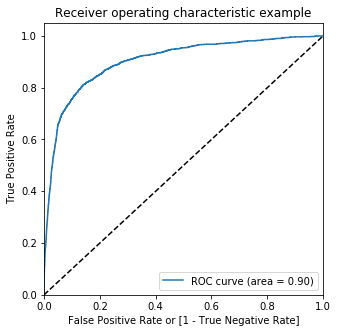

In [686]:
draw_roc(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)

In [687]:
#Finding Optimal Cutoff Point
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,CustID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.015119,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0.532153,1,1,1,1,1,1,1,1,0,0,0,0
2,0,0.028411,2,0,1,0,0,0,0,0,0,0,0,0
3,0,0.009134,3,0,1,0,0,0,0,0,0,0,0,0
4,0,0.000037,4,0,1,0,0,0,0,0,0,0,0,0


In [688]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.083560  1.000000  0.000000
0.1   0.1  0.842944  0.821347  0.844913
0.2   0.2  0.909048  0.712329  0.926984
0.3   0.3  0.926933  0.602740  0.956492
0.4   0.4  0.931225  0.444064  0.975644
0.5   0.5  0.930653  0.316210  0.986677
0.6   0.6  0.927744  0.215753  0.992662
0.7   0.7  0.926217  0.148402  0.997138
0.8   0.8  0.922927  0.088470  0.999011
0.9   0.9  0.919063  0.032534  0.999896


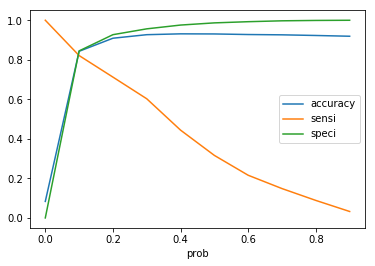

In [689]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [690]:
#From the curve above, 0.09 is the optimum point to take it as a cutoff probability... 
#we need good Sensitivity as per the need of the model thus taking even lesser value

y_train_pred_final['final_predicted'] = y_train_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.05 else 0)

y_train_pred_final.head()

,Churn,Churn_Prob,CustID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.015119,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0.532153,1,1,1,1,1,1,1,1,0,0,0,0,1
2,0,0.028411,2,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.009134,3,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0.000037,4,0,1,0,0,0,0,0,0,0,0,0,0


In [691]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.final_predicted)

0.7402585014546669

In [692]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.final_predicted )
confusion2

array([[13950,  5265],
       [  181,  1571]], dtype=int64)

In [693]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [694]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.896689497716895

In [695]:
# Let us calculate specificity
TN / float(TN+FP)

0.7259953161592506

In [696]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.27400468384074944


In [697]:
# Positive predictive value 
print (TP / float(TP+FP))

0.22981275599765946


In [698]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9871912815795061


In [699]:
#Precision and Recall

confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
confusion

#Precision
print(confusion[1,1]/(confusion[0,1]+confusion[1,1]))

#Recall
print(confusion[1,1]/(confusion[1,0]+confusion[1,1]))

0.6839506172839506
0.3162100456621005


In [700]:
#Feature coefficient values
res.params.sort_values(ascending=False)

Avg67_total_ic_mou    0.545007
DaysFromLastRech      0.331029
Avg67_arpu            0.289601
max_rech_amt_8        0.233451
Avg67_total_og_mou    0.209501
Avg67_roam_og_mou     0.171909
Avg67_vol_2g_mb       0.163292
Avg67_sachet_3g       0.150258
Avg67_sachet_2g       0.139895
monthly_3g_8         -0.153627
Avg67_monthly_2g     -0.189560
vol_2g_mb_8          -0.220753
monthly_2g_8         -0.241052
sachet_3g_8          -0.253260
aug_vbc_3g           -0.271977
aon                  -0.282131
loc_og_mou_8         -0.312126
arpu_8               -0.326302
fb_user_8            -0.351958
last_day_rch_amt_8   -0.371970
sachet_2g_8          -0.479441
total_og_mou_8       -0.651988
spl_ic_mou_8         -0.748018
total_ic_mou_8       -1.055449
sep_vbc_3g           -1.125404
loc_ic_mou_8         -1.421905
const                -4.371918
dtype: float64

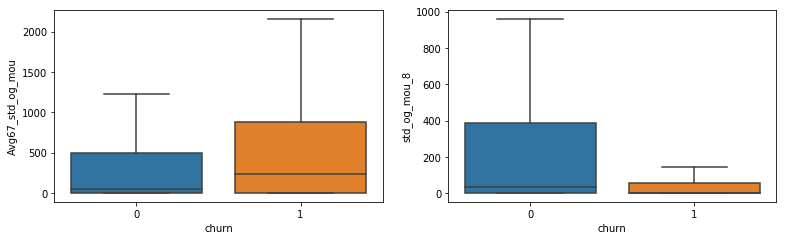

In [701]:
plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(x = 'churn', y = 'Avg67_std_og_mou', data = churnDataHighEndCust, showfliers=False)
plt.subplot(3,3,2)
sns.boxplot(x = 'churn', y = 'std_og_mou_8', data = churnDataHighEndCust, showfliers=False)

#There is sharp drop in STD outgoing calls in 8th month, outgoing STD rates can be reviewed by company to retain customers

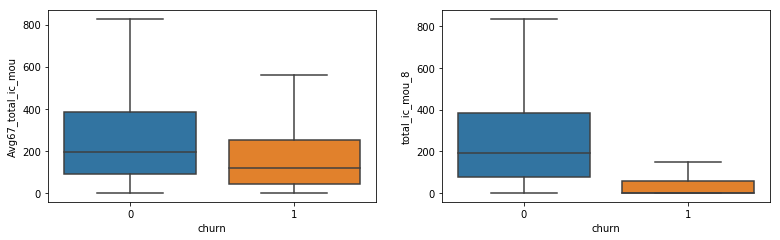

In [702]:
plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(x = 'churn', y = 'Avg67_total_ic_mou', data = churnDataHighEndCust, showfliers=False)
plt.subplot(3,3,2)
sns.boxplot(x = 'churn', y = 'total_ic_mou_8', data = churnDataHighEndCust, showfliers=False)

#Incoming MOU are dropping sharply in 8th month for Churn customer, probably they have already taken alternate number
#and started using that for incoming calls
#Actions --> monitor incoming MOU for customers and if there is sharp drop then those customers can be talked for issues 

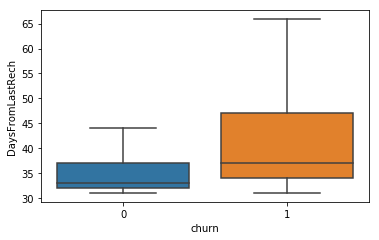

In [703]:
plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(x = 'churn', y = 'DaysFromLastRech', data = churnDataHighEndCust, showfliers=False)

#Customers who are not charging the phone for >40 days - are to be checked and handled on each customer basis

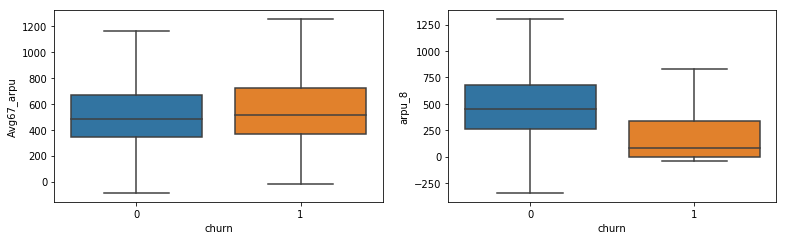

In [704]:
#Avg67_arpu            

plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(x = 'churn', y = 'Avg67_arpu', data = churnDataHighEndCust, showfliers=False)
plt.subplot(3,3,2)
sns.boxplot(x = 'churn', y = 'arpu_8', data = churnDataHighEndCust, showfliers=False)

#Visible difference in Average Revenue per user in 8th month, Churn customers are not recharging
#Check on these customers - call and find out on why they are not charging

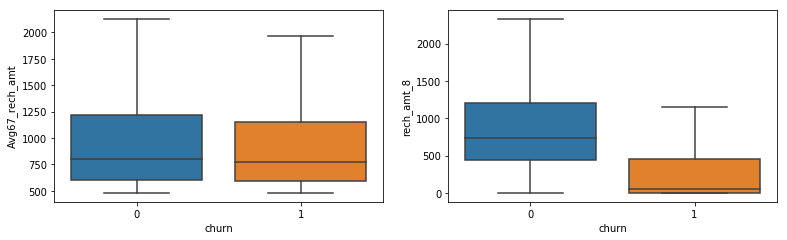

In [705]:
#rech_amt_8
plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(x = 'churn', y = 'Avg67_rech_amt', data = churnDataHighEndCust, showfliers=False)
plt.subplot(3,3,2)
sns.boxplot(x = 'churn', y = 'rech_amt_8', data = churnDataHighEndCust, showfliers=False)

#Customers have stopped recharge in 8th month almost

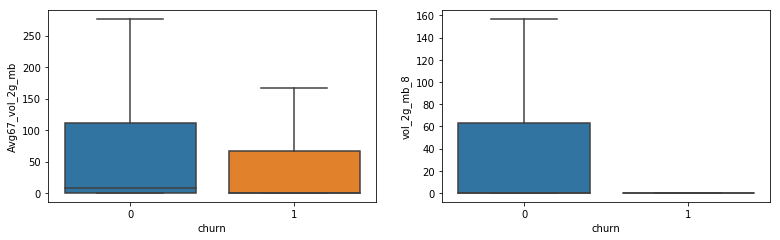

In [706]:
plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(x = 'churn', y = 'Avg67_vol_2g_mb', data = churnDataHighEndCust, showfliers=False)
plt.subplot(3,3,2)
sns.boxplot(x = 'churn', y = 'vol_2g_mb_8', data = churnDataHighEndCust, showfliers=False)

#Customers have stopped recharge in 8th month almost

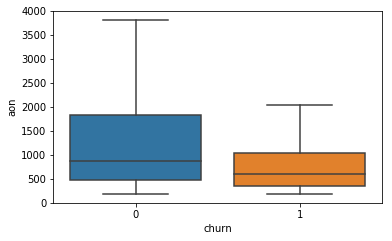

In [707]:
plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(x = 'churn', y = 'aon', data = churnDataHighEndCust, showfliers=False)

#New customers are more likely to churn - keep close watch 

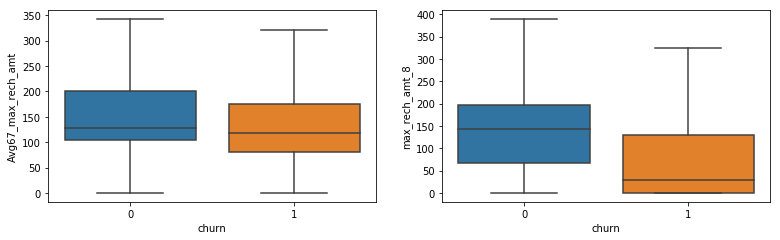

In [708]:
#max_rech_amt_8

plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(x = 'churn', y = 'Avg67_max_rech_amt', data = churnDataHighEndCust, showfliers=False)
plt.subplot(3,3,2)
sns.boxplot(x = 'churn', y = 'max_rech_amt_8', data = churnDataHighEndCust, showfliers=False)

#Small recharges are being done in 8th month for Churn customers
#Give some offer to customers for Higher recharge with longer validity - might retain these customers

#Recommended strategies to manage customer churn

- High value customer churn is around 10%
- Data analysis is needed for customers on month-month basis to find out mainly on Recharge, MOU, Revenue etc
- There is sharp drop in STD outgoing calls in 8th month, outgoing STD rates can be reviewed by company to retain customers
- Monitor incoming MOU for customers and if there is a sudden sharp drop then those customers can be talked for issues
- Customers who are not charging the phone for >40 days - are to be checked and handled on each customer basis
- Customers who are doing small recharges in 8th month are more probable as Churn customers, Give some offer to customers for Higher recharge with longer validity - might retain these customers
- 